**LSE Data Analytics Online Career Accelerator**

**Course 2: Data Analytics using Python - Assessment of NHS services' expansion demand through services' capacity and utilization analysis**

# Objective & focus of analysis

<p>!!! Please refer to the attached report (.pdf) for the explanation how business objective is refined to actionable analytic questions.</p>

<p>Focus of this notebook (analytic questions):
    <ol>
        <li>What was the actual utilisation of resources? (exploratory analysis)
            <ul>
                <li>What is the number of locations, service settings, context types, national categories, and appointment statuses in the data sets?</li>
                <li>What is the date range of the provided data sets, and which service settings reported the most appointments for a specific period?</li>
                <li>What are the insightful utilisation patterns? (categorical analysis)</li>
                <li>What are the top trending hashtags (#) on the supplied Twitter data set and how can this be used in the decision-making process?</li>
            </ul>
        </li>
        <li>Has there been adequate staff and capacity in the networks? (explanatory analysis)
            <ul>
                <li>What are the utilisation trends (capacity vs demand)? Why?</li>
                <li>What is the number of appointments and records per month? Why?</li>
                <li>What monthly and seasonal trends are evident, based on the number of appointments for service settings, context types, and national categories? Why?</li>
                <li>Historic tends' reasoning through open-source research to answer why</li>
            </ul>
        </li>
    </ol>
</p>

# Analysis

## APPROACH

<p>!!! Please refer to the attached report (.pdf) for the explanation of the technical and logical approach.</p>
<p>Sources of periods of COVID lockdowns and school breaks are listed in the attached report.</p>
<p>List of processed data sets:
    <ol>
        <li>Provided:
            <ul>
                <li>'actual_duration.csv'</li>
                <li>'appointments_regional.csv'</li>
                <li>'national_categories.xlsx'</li>
                <li>'tweets.csv'</li>
            </ul>
        </li>
        <li>Additional:
            <ul>
                <li>ONS names of regions<a href="https://www.ons.gov.uk/visualisations/dvc2493/nhs-sankey/datadownload.xlsx)"> (download link)</a>. For simplicity 7 regions were mapped by hand with their names based on the file.</li>
                <li>'gp-reg-pat-prac-all.csv'<a href="https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice#latest-statistics"> - number of registered patients by practice</a> - as a suggestion to use for capacity analysis and planning (see further details in the report and presentation)</li>
            </ul>
        </li>
    </ol>
</p>

## PREPARATIONS 

### Workstation

In [884]:
# Import the necessary libraries.
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.dates import * # for charts axis
import textwrap

# Show plots
%matplotlib inline

# Optional - Ignore warnings.
import warnings
warnings.filterwarnings('ignore')

In [885]:
# Notebook is created in the following versions of libraries:
# print(matplotlib.__version__)
# print(sns.__version__)

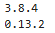

### Formatting

In [888]:
# comma separate floats, decimals to 0
pd.options.display.float_format = '{:,.2f}'.format

# identify empty cells as NA or NaN for missing values checks
pd.options.mode.use_inf_as_na = True

# Prettier plotting with seaborn
sns.set(font_scale=1.5)

# Ticks instead of whitegrid, coloyr palette
sns.set_style('whitegrid')
sns.color_palette('colorblind')

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

### Functions

#### All

In [891]:
# This block lists user created functions for code and outputs' optimisation

# ____________________________FOR CF:________________________________
# "columns_miss_count" and "df_dup" are not combined to run separatly
# when necessary
def columns_miss_count(df):
    """only for columns with missing values count total number of missing values;
    renders shorter list than 'df.isnull().sum()')"""
    null_columns_list = df.isnull().sum()[df.columns[df.isnull().any()]]
    if null_columns_list.empty:
        return f"No missing values"
    else:
        return null_columns_list


def df_dup(x):
    """only list those rows that are duplicated or notify that there are none"""
    dup_rows = x[x.duplicated()]
    if dup_rows.empty:
        return f"No duplicated rows"
    else:
        return f"{len(dup_rows)} duplicate row(s) based on all columns:\n"       


def format_numbers(x):
    """introduce thousands separators and reduce decimals to zero
        (to be applied before .reset_index())"""
    if isinstance(x, (int, float)):
        return "{:,.0f}".format(x)
    else:
        return x
    return x


def wrap_text(text, width=30):
    """wrap lengthy lines of text"""
    
    return "\n".join(textwrap.wrap(text, width=width))


def wrap_text_narrow(text, width=15):
    """wrap lengthy lines of text"""
    
    return "\n".join(textwrap.wrap(text, width=width))

#### barplot_in_array

In [893]:
def barplot_in_array(data, 
                     work_axis,
                     categ_col, 
                     value_col,
                     subtitle, 
                     ylabel,
                     avgcapacity=False,
                     legend=False,
                     **kwargs):
    
    """plot a barplot (in an array)"""
    
    # Plot the barplot
    sns.barplot(x=categ_col, y=value_col, data=data, ax=work_axis,
                linewidth=2, **kwargs)
    work_axis.xaxis.set_label_text(None) # it is obvious from plot title
    work_axis.yaxis.set_label_text(ylabel, fontsize=11)
    work_axis.set_xticks(data[categ_col].apply(wrap_text))
    work_axis.tick_params(axis='x', labelrotation=15, labelsize=12, 
                          length=20, direction='in')
    work_axis.set_yticklabels([])
    work_axis.grid(True, linestyle="--", alpha=0.5)
    work_axis.set_title(subtitle, fontsize=12)
    work_axis.set_ylim([data[value_col].min()*0.1,\
                        data[value_col].max()*1.3])
    
    if avgcapacity:
        # Plot with daily average 30 000 000 appointments
        work_axis.axhline(y=30000000, linestyle='-', color='red')
    
    # Customize the plot:
    # Annotate bars
    for container in work_axis.containers:
        work_axis.bar_label(container, fmt=lambda x: f'{x /1000000:.1f}', fontsize='medium')

    # Depict legend
    if legend:
        work_axis.legend(loc='best', fancybox=True, framealpha=0.5, fontsize='x-small')

In [894]:
# # ____________________________use info:________________________________
# # Examples how to call the function

# fig, ax = plt.subplots(2, 1, figsize=(9, 6))
# fig.suptitle('Appointments by category per month', fontsize=14, y=1.05)

# # # for 1x1 canvas
# # barplot_in_array(data=ar_monthly_sta,
# #                  work_axis=ax,
# #                  avgcapacity=False,
# #                  categ_col='appointment_month', 
# #                  value_col='count_of_appointments', 
# #                  subtitle="by status", 
# #                  ylabel="Num. of appointments, 10^6",
# #                  legend=False,
# #                  hue='appointment_status')
# #
# # for array of plots
# barplot_in_array(data=ar_monthly_hcp,
#                  work_axis=ax[0],
#                  avgcapacity=False,
#                  categ_col='appointment_month', 
#                  value_col='count_of_appointments', 
#                  subtitle="by health care professional type", 
#                  ylabel="Num. of appointments, 10^6",
#                  legend=False,
#                  hue='hcp_type')
# fig.tight_layout(h_pad=1) # fixes overlapping titles
# plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
# fig.show()

#### time_series_plot_with_trendline

In [896]:
def time_series_plot_with_trendline(data, 
                                    work_axis,
                                    time_col, 
                                    value_col,
                                    subtitle, 
                                    ylabel,
                                    avgcapacity=False,
                                    trendline=False,
                                    seasons_ad=False,
                                    seasons_ar=False,
                                    seasons_nc=False,
                                    lockdowns=False,
                                    lockdowns_alt=False,
                                    schoolbreaks=False,
                                    **kwargs):
    
    """plot a lineplot with a trendline (in an array)"""
    #make sure time column is in datetime format
    data[time_col] = pd.to_datetime(data[time_col])
    
    #sort DataFrame by the time column
    data.sort_values(by=time_col, inplace=True)

    
    # Plot the time series
    sns.lineplot(x=time_col, y=value_col, data=data, ax=work_axis,
                     ci=None, linewidth=2, **kwargs)
    work_axis.xaxis.set_label_text(None)
    work_axis.yaxis.set_label_text(ylabel, fontsize=12)
    work_axis.set_xticks(data[time_col])
    work_axis.tick_params(axis='x', labelrotation=55, labelsize=10)
    work_axis.set_yticklabels(work_axis.get_yticks()/1000000, fontsize=11)
    work_axis.grid(True, linestyle="--", alpha=0.5)
    work_axis.set_title(subtitle, fontsize=12)

    if avgcapacity:
        # Plot with monthly average 30 000 000 appointments
        work_axis.axhline(y=30000000, linestyle='-', color='red', label="Avg. monthly capacity")
        # Adjust y-axis limit
        work_axis.set_ylim([data[value_col].min()*0.9,\
                            data[value_col].max()*1.1])
        work_axis.set_yticklabels(work_axis.get_yticks()/1000000, fontsize=11)
    
    if trendline:
        # work_axis.set_ylim([data[value_col].min()*0.9,\
        #                     data[value_col].max()*1.1])
        #Calculate trendline
        x = np.arange(len(data))
        y = data[value_col].values
        z = np.polyfit(x, y, 1)
        p = np.poly1d(z)
        
        # Plot the trendline
        work_axis.plot(data[time_col], p(x), linestyle='--', 
                       color='#17BECF', label='Trendline')
        work_axis.set_yticklabels(work_axis.get_yticks()/1000000, fontsize=11)

    if seasons_ad:
        # Highlight seasons
        work_axis.axvspan("2020-12-01", "2021-03-01", fc="b", alpha=0.25)
        work_axis.axvspan("2021-03-01", "2021-06-01", fc="r", alpha=0.25, label="Spring")
        work_axis.axvspan("2021-06-01", "2021-09-01", fc="y", alpha=0.25, label="Summer")
        work_axis.axvspan("2021-09-01", "2021-12-01", fc="c", alpha=0.25, label="Autumn")
        work_axis.axvspan("2021-12-01", "2022-03-01", fc="b", alpha=0.25, label="Winter")
        work_axis.axvspan("2022-03-01", "2022-06-30", fc="r", alpha=0.25)
        
    if seasons_ar:
        # Highlight seasons
        work_axis.axvspan("2020-01-01", "2020-03-01", fc="b", alpha=0.25)
        work_axis.axvspan("2020-03-01", "2020-06-01", fc="r", alpha=0.25)
        work_axis.axvspan("2020-06-01", "2020-09-01", fc="y", alpha=0.25)
        work_axis.axvspan("2020-09-01", "2020-12-01", fc="c", alpha=0.25)
        work_axis.axvspan("2020-12-01", "2021-03-01", fc="b", alpha=0.25)
        work_axis.axvspan("2021-03-01", "2021-06-01", fc="r", alpha=0.25, label="Spring")
        work_axis.axvspan("2021-06-01", "2021-09-01", fc="y", alpha=0.25, label="Summer")
        work_axis.axvspan("2021-09-01", "2021-12-01", fc="c", alpha=0.25, label="Autumn")
        work_axis.axvspan("2021-12-01", "2022-03-01", fc="b", alpha=0.25, label="Winter")
        work_axis.axvspan("2022-03-01", "2022-06-01", fc="r", alpha=0.25)

    if seasons_nc:
        # Highlight seasons
        work_axis.axvspan("2021-08-01", "2021-09-01", fc="y", alpha=0.25, label="Summer")
        work_axis.axvspan("2021-09-01", "2021-12-01", fc="c", alpha=0.25, label="Autumn")
        work_axis.axvspan("2021-12-01", "2022-03-01", fc="b", alpha=0.25, label="Winter")
        work_axis.axvspan("2022-03-01", "2022-06-01", fc="r", alpha=0.25, label="Spring")
    
    if lockdowns:
        # # Adjust y-axis limit
        work_axis.set_ylim(data[value_col].min()*0.9,\
                            top=None)
        
        # Create mask to specify time frame
        fill_bn_mask_1st = (data[time_col] >= "2020-03-23") &\
                           (data[time_col] <= "2020-06-15")
        
        fill_bn_mask_2nd = (data[time_col] >= "2020-11-01") &\
                           (data[time_col] <= "2020-12-01") # actually 2020-11-05-2020-12-02
        
        fill_bn_mask_3rd = (data[time_col] >= "2021-01-01") &\
                           (data[time_col] <= "2021-03-08")

        fill_bn_mask_tier = (data[time_col] >= "2020-12-02") &\
                            (data[time_col] <= "2021-07-19")
       
        # Highlight relevant area under the curve
        work_axis.fill_between(data[time_col],
                               data[value_col],
                               data[value_col].min()*0.9,
                               where = fill_bn_mask_1st, fc='m', 
                               alpha=0.5, label="3 lockdowns")
        work_axis.fill_between(data[time_col],
                               data[value_col],
                               data[value_col].min()*0.9,
                               where = fill_bn_mask_2nd, fc='m', 
                               alpha=0.5)
        work_axis.fill_between(data[time_col],
                               data[value_col],
                               data[value_col].min()*0.9,
                               where = fill_bn_mask_3rd, fc='m', 
                               alpha=0.5)
        work_axis.fill_between(data[time_col],
                               data[value_col],
                               data[value_col].min()*0.9,
                               where = fill_bn_mask_tier, fc='c', 
                               alpha=0.5, label="COVID Tier")

    if lockdowns_alt:
        # Alternative lockdowns highlight for plots with hue:
        work_axis.axvspan("2020-03-23", "2020-06-15", fc="m", alpha=0.25, label="3 lockdowns")
        work_axis.axvspan("2020-11-01", "2020-12-01", fc="m", alpha=0.25, label="COVID Tier")
        work_axis.axvspan("2021-01-01", "2021-03-08", fc="m", alpha=0.25)
        work_axis.axvspan("2020-12-02", "2021-07-19", fc="c", alpha=0.25)        
    
    if schoolbreaks:
        # Highlight school breaks
        work_axis.axvspan("2021-07-19", "2021-09-01", fc="g", alpha=0.25, label="Term breaks")
        work_axis.axvspan("2021-10-24", "2021-11-01", fc="k", alpha=0.25, label="Half-Term breaks")
        work_axis.axvspan("2021-12-20", "2022-01-06", fc="g", alpha=0.25)
        work_axis.axvspan("2022-02-17", "2022-03-01", fc="k", alpha=0.25)
        work_axis.axvspan("2022-04-04", "2022-05-01", fc="g", alpha=0.25)
        work_axis.axvspan("2022-05-26", "2022-06-02", fc="k", alpha=0.25)
    
    # Customize the plot
    work_axis.legend(loc='best', fancybox=True, framealpha=0.5, fontsize=9)

In [897]:
# # ____________________________use info:________________________________
# # Examples how to call the function
# fig, ax = plt.subplots(2, 1, figsize=(10, 6))
# fig.suptitle('Appointments by category per month', fontsize=14, y=1.05)

# # for 1x1 canvas
# # time_series_plot_with_trendline(data=ar_monthly_sta,
# #                                 work_axis=ax,
# #                                 avgcapacity=False,
# #                                 trendline=True,
# #                                 seasons_ad=False,
# #                                 seasons_ar=True,
# #                                 seasons_nc=False,
# #                                 lockdowns=False,
# #                                 schoolbreaks=False,
# #                                 time_col='appointment_month', 
# #                                 value_col='count_of_appointments', 
# #                                 subtitle="by status", 
# #                                 ylabel="Num. of appointments, 10^6",
# #                                 hue='appointment_status')
# # for array of plots
# time_series_plot_with_trendline(data=ar_monthly_hcp,
#                                 work_axis=ax[0],
#                                 avgcapacity=False,
#                                 trendline=True,
#                                 seasons_ad=False,
#                                 seasons_ar=True,
#                                 seasons_nc=False,
#                                 lockdowns=False,
#                                 schoolbreaks=False,
#                                 time_col='appointment_month', 
#                                 value_col='count_of_appointments', 
#                                 subtitle="by health care professional type", 
#                                 ylabel="Num. of appointments, 10^6",
#                                 hue='hcp_type')
# fig.tight_layout(h_pad=0.5) # fixes overlapping titles
# plt.subplots_adjust(top=1, wspace=0.12) # fixes overlapping titles
# fig.show()

# Exploratory analysis: What was the actual utilisation of resources?

## AD -'actual_duration.csv' - explore data set

In [900]:
# Import and sense-check the actual_duration.csv data set as ad.
ad = pd.read_csv('actual_duration.csv')

print('actual_duration dataset:')
print(ad.shape)

# Determine the metadata, data types of the data set
ad.info()

actual_duration dataset:
(137793, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB


In [901]:
ad.head(2)

sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date actual_duration  count_of_appointments  
0        01-Dec-21   31-60 Minutes                    364  
1        01-Dec-21   21-30 Minutes                    619

In [902]:
# ____________________________FOR CF:________________________________
#'pd_datetime()', '.format="%d-%m-%Y" ', 
#'.dt.normalize()', '.dt.floor('D')' not considered as
# it leaves a timestamp interfering plotting with lengthy axis values 

# convert dates to Python date type, eliminate time
# .dt.date eliminates timestamp

print(ad['appointment_date'].dtype)
ad['appointment_date'] = pd.to_datetime(ad['appointment_date']).dt.date
print(ad['appointment_date'].dtype)

object
object


In [903]:
# 1.1 View the DataFrame.
# only 2 rows - for the sake of optimised memory usage
ad.head(2)

sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date actual_duration  count_of_appointments  
0       2021-12-01   31-60 Minutes                    364  
1       2021-12-01   21-30 Minutes                    619

In [904]:
# 1.2 View the DataFrame.
ad.tail(2)

sub_icb_location_code sub_icb_location_ons_code  \
137791                 X2C4Y                 E38000254   
137792                 X2C4Y                 E38000254   

                 sub_icb_location_name icb_ons_code region_ons_code  \
137791  NHS West Yorkshire ICB - X2C4Y    E54000054       E40000012   
137792  NHS West Yorkshire ICB - X2C4Y    E54000054       E40000012   

       appointment_date actual_duration  count_of_appointments  
137791       2022-06-30   11-15 Minutes                   1439  
137792       2022-06-30     1-5 Minutes                   1739

>Replace region codes with names of regions from [ONS](https://www.ons.gov.uk/visualisations/dvc2493/nhs-sankey/datadownload.xlsx)

In [906]:
# Replace values using a dictionary mapping
ad['region_name'] = ad['region_ons_code'].map({
                        'E40000003': 'London', 
                        'E40000005': 'South East',
                        'E40000006': 'South West',
                        'E40000007': 'East of England',
                        'E40000010': 'North West',
                        'E40000011': 'Midlands',
                        'E40000012': 'North East and Yorkshire'})

In [907]:
# Determine whether there are missing values.
columns_miss_count(ad)

'No missing values'

In [908]:
# Determine whether there are duplicated rows.
df_dup(ad)

'No duplicated rows'

In [909]:
# Determine the descriptive statistics of the data set.
# 1.1. for numeric data
ad.describe()

count_of_appointments
count             137,793.00
mean                1,219.08
std                 1,546.90
min                     1.00
25%                   194.00
50%                   696.00
75%                 1,621.00
max                15,400.00

In [910]:
# 1.2. include objects
ad.describe(include = ['O'])

sub_icb_location_code sub_icb_location_ons_code  \
count                 137793                    137793   
unique                   106                       106   
top                      26A                 E38000239   
freq                    1484                      1484   

                    sub_icb_location_name icb_ons_code region_ons_code  \
count                              137793       137793          137793   
unique                                106           42               7   
top     NHS Norfolk and Waveney ICB - 26A    E54000057       E40000010   
freq                                 1484        12668           33112   

       appointment_date         actual_duration region_name  
count            137793                  137793      137793  
unique              212                       7           7  
top          2021-12-01  Unknown / Data Quality  North West  
freq                742                   20161       33112

In [911]:
ad.head(2)

sub_icb_location_code sub_icb_location_ons_code  \
0                   00L                 E38000130   
1                   00L                 E38000130   

                        sub_icb_location_name icb_ons_code region_ons_code  \
0  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   
1  NHS North East and North Cumbria ICB - 00L    E54000050       E40000012   

  appointment_date actual_duration  count_of_appointments  \
0       2021-12-01   31-60 Minutes                    364   
1       2021-12-01   21-30 Minutes                    619   

                region_name  
0  North East and Yorkshire  
1  North East and Yorkshire

In [912]:
# Sum of appointments by region
ad_sub_region = ad.groupby('region_name')['count_of_appointments']\
                     .sum().sort_values(ascending=False)
ad_sub_region = ad_sub_region.apply(format_numbers)
ad_sub_region

region_name
Midlands                    32,574,555
North East and Yorkshire    27,425,610
South East                  25,577,953
London                      24,488,519
North West                  19,880,924
East of England             19,546,694
South West                  18,486,437
Name: count_of_appointments, dtype: object

In [913]:
# Daily average of appointments by region
ad_sub_region = ad.groupby('region_name')['count_of_appointments']\
                     .mean().sort_values(ascending=False)
ad_sub_region = ad_sub_region.apply(format_numbers)
ad_sub_region

region_name
London                      3,439
South West                  1,953
South East                  1,691
Midlands                    1,302
East of England             1,035
North East and Yorkshire      944
North West                    600
Name: count_of_appointments, dtype: object

In [914]:
# Plot average appointments by region
# required time frame coinsides with common across data sets
# plt.figure(figsize=(7, 3))
# plt.title("Distribution of appointments a day by region", fontsize=14)
# plt.tight_layout() # fixes overlapping titles
# sns.boxplot(data=ad, order=ad_sub_region.index,
#             x='count_of_appointments',
#             y='region_name', linewidth=1, notch=True)

That is the wrong way to identify outliers in a timeseries data, instead group by month/day and compare the timeline with any historical medical phenomena or alternative logical explanation - see "ad_fig_distribution_outliers".

## - Analyst's observations:

- For statistics to depict diverse sets use -> [Data types syntax](https://stackoverflow.com/a/37562101/21407272).
- See reasoning behind frequent December appointments.
- Outliers: could not be eliminated due to aggregated data, are not to be eliminated as this might be justifiable spikes (epidemic etc.) - look into timeseries and align with historical open-source info.
- Map 'region_ons_code', 'icb_ons_code' with actual names from [arcGIS](https://www.arcgis.com/home/item.html?id=2bca16d4f8e4426d80137213fce90bbd&sublayer=0#data) (place code at the beginning) - done.
- Also match with the rest of the data sets in case need to merge:

In [918]:
# What range of services locations is covered
num_sub_icbs = ad['sub_icb_location_name'].nunique()
num_icbs = ad['icb_ons_code'].nunique()
num_regions = ad['region_ons_code'].nunique()

print(
f"""There are {num_sub_icbs} sub_icbs in   'sub_icb_location_code', 
                            'sub_icb_location_ons_code',
                            'sub_icb_location_name'
There are {num_icbs} icbs in 'icb_ons_code'
There are {num_regions} regions in 'region_ons_code'"""
    )

There are 106 sub_icbs in   'sub_icb_location_code', 
                            'sub_icb_location_ons_code',
                            'sub_icb_location_name'
There are 42 icbs in 'icb_ons_code'
There are 7 regions in 'region_ons_code'


In [919]:
# Snapshot of reported services structure 
ad_sub_services = ad[['sub_icb_location_name', 
                        'icb_ons_code', 
                        'region_name']]

ad_slice_services = ad_sub_services.groupby(['region_name', 
                                               'icb_ons_code', 
                                               'sub_icb_location_name']) \
                                        .region_name.count()

# Show (the full) rendered list
# with pd.option_context('display.max_rows', None,):
#     print(ad_slice_services)
ad_slice_services

region_name      icb_ons_code  sub_icb_location_name                                           
East of England  E54000022     NHS Norfolk and Waveney ICB - 26A                                   1484
                 E54000023     NHS Suffolk and North East Essex ICB - 06L                          1221
                               NHS Suffolk and North East Essex ICB - 06T                          1469
                               NHS Suffolk and North East Essex ICB - 07K                          1203
                 E54000024     NHS Bedfordshire Luton and Milton Keynes ICB - M1J4Y                1484
                                                                                                   ... 
South West       E54000038     NHS Somerset ICB - 11X                                              1207
                 E54000039     NHS Bristol North Somerset and South Gloucestershire ICB - 15C      1365
                 E54000040     NHS Bath and North East Somerset Swindon 

>[source](https://stackoverflow.com/a/64142833/21407272):

In [922]:
# Calculate number of ICBs and sub-ICBs in each region
ad_sub_services.copy()
ad_services_breakdown = (ad_sub_services.groupby('region_name')[['icb_ons_code', 
                                                        'sub_icb_location_name']]\
                       .apply(lambda group: group.apply(pd.Series.nunique))\
                       .fillna(0))
ad_services_breakdown

icb_ons_code  sub_icb_location_name
region_name                                                  
East of England                      6                     14
London                               5                      5
Midlands                            11                     19
North East and Yorkshire             4                     23
North West                           3                     27
South East                           6                     11
South West                           7                      7

In [923]:
# Summarise number of services
ad[['sub_icb_location_name', 
    'icb_ons_code', 
    'region_ons_code']].T.apply(lambda x: x.nunique(), axis=1)

sub_icb_location_name    106
icb_ons_code              42
region_ons_code            7
dtype: int64

In [924]:
# What is the total number of appointments
ad_ca_sumall = ad['count_of_appointments'].sum()

# What is the average number of appointments a day
ad_ca_avgday = ad.groupby('appointment_date') \
                    .agg({'count_of_appointments': 'sum'}).mean()


# average appointments by region
ad_ca_avgreg = ad.groupby('region_ons_code') \
                    .agg({'count_of_appointments': 'sum'}).mean()

# average appointments by region a day
ad_ca_avgregday = ad.groupby(['region_ons_code', 'appointment_date']) \
                    .agg({'count_of_appointments': 'sum'}).mean()

# average appointments by ICB
ad_ca_avgicb = ad.groupby('icb_ons_code') \
                    .agg({'count_of_appointments': 'sum'}).mean()

# average appointments by ICB a day
ad_ca_avgicbday = ad.groupby(['icb_ons_code', 'appointment_date']) \
                    .agg({'count_of_appointments': 'sum'}).mean()

# average appointments by sub-ICB
ad_ca_avgsicb = ad.groupby('sub_icb_location_name') \
                    .agg({'count_of_appointments': 'sum'}).mean()

# average appointments by sub-ICB a day
ad_ca_avgsicbday = ad.groupby(['sub_icb_location_name', 'appointment_date']) \
                    .agg({'count_of_appointments': 'sum'}).mean()

In [925]:
# Output findings
print(
f"""There are           {ad_ca_sumall:,.0f} total appointments:
with the average of     {(ad_ca_avgday.item()):,.0f} appointments / day across {len(ad.groupby('appointment_date'))} days
with the average of  {(ad_ca_avgreg.item()):,.0f} appointments across       {num_regions} regions
with the average of     {(ad_ca_avgregday.item()):,.0f} appointments / day per region
with the average of   {(ad_ca_avgicb.item()):,.0f} appointments across       {num_icbs} ICBs
with the average of      {(ad_ca_avgicbday.item()):,.0f} appointments / day per ICB
with the average of   {(ad_ca_avgsicb.item()):,.0f} appointments across       {num_sub_icbs} sub-ICBs
with the average of       {(ad_ca_avgsicbday.item()):,.0f} appointments / day per sub-ICB"""
    )

There are           167,980,692 total appointments:
with the average of     792,362 appointments / day across 212 days
with the average of  23,997,242 appointments across       7 regions
with the average of     113,195 appointments / day per region
with the average of   3,999,540 appointments across       42 ICBs
with the average of      19,313 appointments / day per ICB
with the average of   1,584,724 appointments across       106 sub-ICBs
with the average of       8,184 appointments / day per sub-ICB


## AR -'appointments_regional.csv' - explore data set

In [927]:
# Import and sense-check the appointments_regional.csv data set as ar.
ar = pd.read_csv('appointments_regional.csv')

print('appointments_regional dataset:')
print(ar.shape)

# Determine the metadata, data types of the data set
ar.info()

appointments_regional dataset:
(596821, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB


In [928]:
ar.head(20)

icb_ons_code appointment_month appointment_status hcp_type  \
0     E54000034           2020-01           Attended       GP   
1     E54000034           2020-01           Attended       GP   
2     E54000034           2020-01           Attended       GP   
3     E54000034           2020-01           Attended       GP   
4     E54000034           2020-01           Attended       GP   
5     E54000034           2020-01           Attended       GP   
6     E54000034           2020-01           Attended       GP   
7     E54000034           2020-01           Attended       GP   
8     E54000034           2020-01           Attended       GP   
9     E54000034           2020-01           Attended       GP   
10    E54000034           2020-01           Attended       GP   
11    E54000034           2020-01           Attended       GP   
12    E54000034           2020-01           Attended       GP   
13    E54000034           2020-01           Attended       GP   
14    E54000034           2020-01           Attended       GP   
15    E54000034           2020-01           Attended       GP   
16    E54000034           2020-01           Attended       GP   
17    E54000034           2020-01           Attended       GP   
18    E54000034           2020-01           Attended       GP   
19    E54000034           2020-01           Attended       GP   

   appointment_mode time_between_book_and_appointment  count_of_appointments  
0      Face-to-Face                             1 Day                   8107  
1      Face-to-Face                    15  to 21 Days                   6791  
2      Face-to-Face                       2 to 7 Days                  20686  
3      Face-to-Face                    22  to 28 Days                   4268  
4      Face-to-Face                     8  to 14 Days                  11971  
5      Face-to-Face                 More than 28 Days                   3273  
6      Face-to-Face                          Same Day                  64649  
7        Home Visit                             1 Day                    151  
8        Home Visit                    15  to 21 Days                     12  
9        Home Visit                       2 to 7 Days                    141  
10       Home Visit                    22  to 28 Days                      4  
11       Home Visit                     8  to 14 Days                     16  
12       Home Visit                 More than 28 Days                      6  
13       Home Visit                          Same Day                    762  
14        Telephone                             1 Day                   3114  
15        Telephone                    15  to 21 Days                    657  
16        Telephone                       2 to 7 Days                   7785  
17        Telephone                    22  to 28 Days                    240  
18        Telephone                     8  to 14 Days                   1972  
19        Telephone                 More than 28 Days                    119

In [929]:
# convert dates to Python date type
print(ar['appointment_month'].dtype)
ar['appointment_month'] = pd.to_datetime(ar['appointment_month']).dt.to_period('M')
print(ar['appointment_month'].dtype)

object
period[M]


In [930]:
# 1.1 View the DataFrame.
# only 2 rows - for the sake of optimised memory usage
ar.head(2)

icb_ons_code appointment_month appointment_status hcp_type appointment_mode  \
0    E54000034           2020-01           Attended       GP     Face-to-Face   
1    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments  
0                             1 Day                   8107  
1                    15  to 21 Days                   6791

In [931]:
# 1.2 View the DataFrame.
ar.tail(2)

icb_ons_code appointment_month appointment_status hcp_type  \
596819    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
596819          Unknown                 More than 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments  
596819                     17  
596820                     10

In [932]:
# Determine whether there are missing values.
columns_miss_count(ar)

'No missing values'

In [933]:
# Determine whether there are duplicated rows.
# See justification below
df_dup(ar)

'21604 duplicate row(s) based on all columns:\n'

In [934]:
# List duplicates for sense check
ar[ar.duplicated()]

icb_ons_code appointment_month appointment_status hcp_type  \
19292     E54000044           2020-01           Attended       GP   
19308     E54000044           2020-01           Attended       GP   
19374     E54000044           2020-01                DNA       GP   
19417     E54000044           2020-01                DNA  Unknown   
19419     E54000044           2020-01                DNA  Unknown   
...             ...               ...                ...      ...   
596809    E54000050           2022-06            Unknown  Unknown   
596812    E54000050           2022-06            Unknown  Unknown   
596814    E54000050           2022-06            Unknown  Unknown   
596817    E54000050           2022-06            Unknown  Unknown   
596820    E54000050           2022-06            Unknown  Unknown   

       appointment_mode time_between_book_and_appointment  \
19292        Home Visit            Unknown / Data Quality   
19308           Unknown            Unknown / Data Quality   
19374        Home Visit                     8  to 14 Days   
19417      Face-to-Face                       2 to 7 Days   
19419      Face-to-Face                          Same Day   
...                 ...                               ...   
596809        Telephone                    15  to 21 Days   
596812        Telephone                 More than 28 Days   
596814          Unknown                             1 Day   
596817          Unknown                    22  to 28 Days   
596820          Unknown                          Same Day   

        count_of_appointments  
19292                       1  
19308                       2  
19374                       1  
19417                       1  
19419                       6  
...                       ...  
596809                      1  
596812                      1  
596814                      2  
596817                      8  
596820                     10  

[21604 rows x 7 columns]

In [935]:
# Determine the descriptive statistics of the data set.
# 1.1. for numeric data
ar.describe()

count_of_appointments
count             596,821.00
mean                1,244.60
std                 5,856.89
min                     1.00
25%                     7.00
50%                    47.00
75%                   308.00
max               211,265.00

In [936]:
# 1.2. include objects
ar.describe(include='all')

icb_ons_code appointment_month appointment_status  \
count        596821            596821             596821   
unique           42                30                  3   
top       E54000057           2020-03           Attended   
freq          54527             21350             232137   
mean            NaN               NaN                NaN   
std             NaN               NaN                NaN   
min             NaN               NaN                NaN   
25%             NaN               NaN                NaN   
50%             NaN               NaN                NaN   
75%             NaN               NaN                NaN   
max             NaN               NaN                NaN   

                    hcp_type appointment_mode  \
count                 596821           596821   
unique                     3                5   
top     Other Practice staff     Face-to-Face   
freq                  241557           180410   
mean                     NaN              NaN   
std                      NaN              NaN   
min                      NaN              NaN   
25%                      NaN              NaN   
50%                      NaN              NaN   
75%                      NaN              NaN   
max                      NaN              NaN   

       time_between_book_and_appointment  count_of_appointments  
count                             596821             596,821.00  
unique                                 8                    NaN  
top                             Same Day                    NaN  
freq                               95502                    NaN  
mean                                 NaN               1,244.60  
std                                  NaN               5,856.89  
min                                  NaN                   1.00  
25%                                  NaN                   7.00  
50%                                  NaN                  47.00  
75%                                  NaN                 308.00  
max                                  NaN             211,265.00

In [937]:
# Determine the number of appointment statuses.
ar['appointment_status'].value_counts().apply(format_numbers)

appointment_status
Attended    232,137
Unknown     201,324
DNA         163,360
Name: count, dtype: object

## - Analyst's observations:

- Duplicates accross icbs are justified by the AD data set which associates 106 sub_icbs with 42 icbs.
- It makes sense that each icb offers multiple appointments of the same type daily.
- Also see mathematical justification in the observations for "Relational? - explore data sets"
- Format month, group by month to calculate average number of appointments per month in line with data structure.
- CONSTRAINT: The lack of 'available' status eliminates staff adequacy analysis within 'Unknown'.

## NC -'national_categories.xlsx' - explore data set

In [941]:
# Import and sense-check the national_categories.xlsx data set as nc.
nc = pd.read_excel('national_categories.xlsx')

print('national_categories dataset:')
print(nc.shape)

# Determine the metadata, data types of the data set
nc.info()

national_categories dataset:
(817394, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB


In [942]:
# Convert dates to Python date type, eliminates timestamp
nc['appointment_date'] = pd.to_datetime(nc['appointment_date']).dt.date

In [943]:
# Convert dates to Python date type
# before:
print(nc['appointment_month'].dtype)

# after:
nc['appointment_month'] = pd.to_datetime(nc['appointment_month']).dt.to_period('M')
print(nc['appointment_month'].dtype)

object
period[M]


In [944]:
# 1.1 View the DataFrame.
# only 2 rows - for the sake of optimised memory usage
nc.head(2)

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   

                        national_category  count_of_appointments  \
0  Patient contact during Care Home Round                      3   
1                         Planned Clinics                      7   

  appointment_month  
0           2021-08  
1           2021-08

In [945]:
# 1.2 View the DataFrame.
nc.tail(2)

appointment_date icb_ons_code           sub_icb_location_name  \
817392       2022-06-30    E54000054  NHS West Yorkshire ICB - X2C4Y   
817393       2022-06-30    E54000054  NHS West Yorkshire ICB - X2C4Y   

                  service_setting            context_type  \
817392  Extended Access Provision  Care Related Encounter   
817393  Extended Access Provision  Care Related Encounter   

                   national_category  count_of_appointments appointment_month  
817392  General Consultation Routine                      4           2022-06  
817393    General Consultation Acute                     19           2022-06

In [946]:
# Determine whether there are missing values.
columns_miss_count(nc)

'No missing values'

In [947]:
# Determine whether there are duplicated rows.
df_dup(nc)

'No duplicated rows'

In [948]:
# Determine the descriptive statistics of the data set.
# 1.1. for numeric data
nc.describe()

count_of_appointments
count             817,394.00
mean                  362.18
std                 1,084.58
min                     1.00
25%                     7.00
50%                    25.00
75%                   128.00
max                16,590.00

In [949]:
# 1.2. include objects
nc.describe(include='all')

appointment_date icb_ons_code              sub_icb_location_name  \
count            817394       817394                             817394   
unique              334           42                                106   
top          2022-06-28    E54000057  NHS North West London ICB - W2U3Z   
freq               3536        59180                              13007   
mean                NaN          NaN                                NaN   
std                 NaN          NaN                                NaN   
min                 NaN          NaN                                NaN   
25%                 NaN          NaN                                NaN   
50%                 NaN          NaN                                NaN   
75%                 NaN          NaN                                NaN   
max                 NaN          NaN                                NaN   

         service_setting            context_type     national_category  \
count             817394                  817394                817394   
unique                 5                       3                    18   
top     General Practice  Care Related Encounter  Inconsistent Mapping   
freq              359274                  700481                 89494   
mean                 NaN                     NaN                   NaN   
std                  NaN                     NaN                   NaN   
min                  NaN                     NaN                   NaN   
25%                  NaN                     NaN                   NaN   
50%                  NaN                     NaN                   NaN   
75%                  NaN                     NaN                   NaN   
max                  NaN                     NaN                   NaN   

        count_of_appointments appointment_month  
count              817,394.00            817394  
unique                    NaN                11  
top                       NaN           2022-03  
freq                      NaN             82822  
mean                   362.18               NaN  
std                  1,084.58               NaN  
min                      1.00               NaN  
25%                      7.00               NaN  
50%                     25.00               NaN  
75%                    128.00               NaN  
max                 16,590.00               NaN

In [950]:
# Determine five locations with the highest number of appointments
nc_group = nc.groupby('sub_icb_location_name')['count_of_appointments'] \
                    .sum().sort_values(ascending=False)
nc_grouped = nc_group.apply(format_numbers)
nc_grouped.head(5)

sub_icb_location_name
NHS North West London ICB - W2U3Z              12,142,390
NHS North East London ICB - A3A8R               9,588,891
NHS Kent and Medway ICB - 91Q                   9,286,167
NHS Hampshire and Isle Of Wight ICB - D9Y0V     8,288,102
NHS South East London ICB - 72Q                 7,850,170
Name: count_of_appointments, dtype: object

In [951]:
# Determine the number of context types.
nc['context_type'].value_counts().apply(format_numbers)

context_type
Care Related Encounter    700,481
Inconsistent Mapping       89,494
Unmapped                   27,419
Name: count, dtype: object

In [952]:
# Determine the number of service settings.
nc['service_setting'].value_counts().apply(format_numbers)

service_setting
General Practice             359,274
Primary Care Network         183,790
Other                        138,789
Extended Access Provision    108,122
Unmapped                      27,419
Name: count, dtype: object

In [953]:
# Determine the number of national categories.
nc['national_category'].value_counts().apply(format_numbers)

national_category
Inconsistent Mapping                                                   89,494
General Consultation Routine                                           89,329
General Consultation Acute                                             84,874
Planned Clinics                                                        76,429
Clinical Triage                                                        74,539
Planned Clinical Procedure                                             59,631
Structured Medication Review                                           44,467
Service provided by organisation external to the practice              43,095
Home Visit                                                             41,850
Unplanned Clinical Activity                                            40,415
Patient contact during Care Home Round                                 28,795
Unmapped                                                               27,419
Care Home Visit                               

## - Analyst's observations:

- Format dates, group by date to calculate average appointments per day in line with data structure
- NC depicts categories of diverse urgency, conduct timeseries analysis for seasonal insights (busiest periods vs capacity?)
- Merging data sets could provide utilisation insights by region - region is in AD, 'icb_ons_code' is the Primary Key across the three sets

## 'gp-reg-pat-prac-all.csv' - explore data set

>The [(NHS England Digital web page)](https://digital.nhs.uk/data-and-information/publications/statistical/patients-registered-at-a-gp-practice#latest-statistics) structure analysis and a quick look at an example data set was sufficient for the following observations/suggestions:

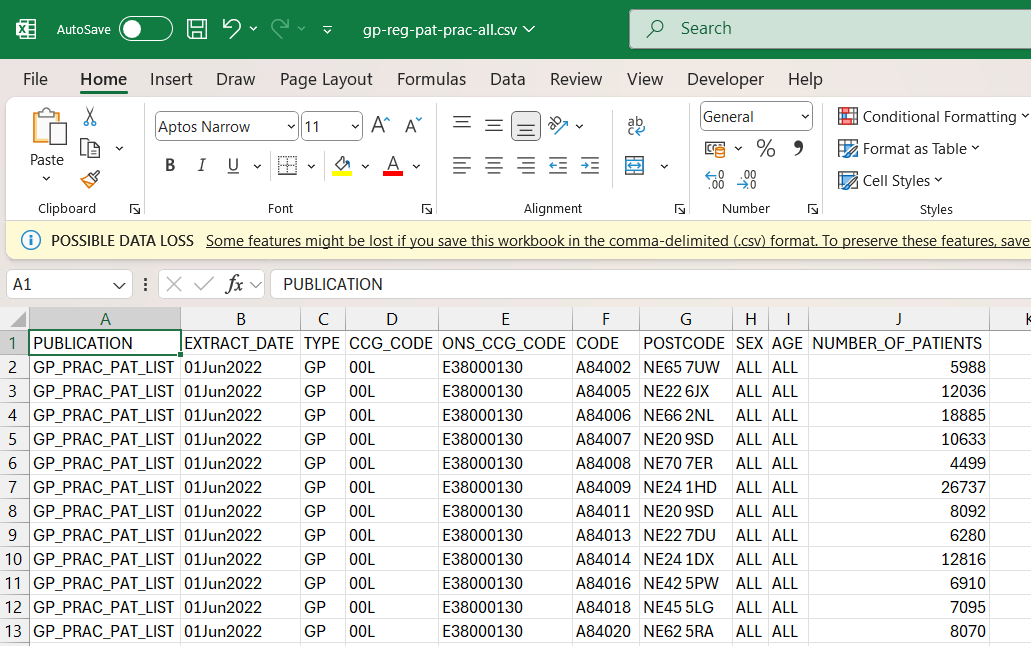

## - Analyst's observations:

- Each data set contains daily numbers of patients registered at a GP by gender.
- Data is collected and stored in a separate file by month.
- It is worth establising before the analysis whether all practices are included.
- Thus when necessary monthly aggregates could be used to establish month-to-month growth rate of the number of registered patients per associated ICB. ICB assocation needs to be established through additional research.
- The rate could further be compared with the demand growth rate (appointments). Appointments' forecast could be compared with the registered growth rate as a method of capacity planning.

## Relational? Duplicates? - explore data sets

Initial data sets' structure:

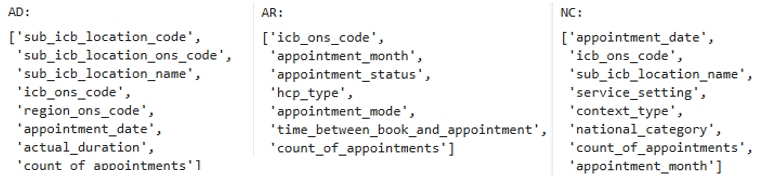

In [964]:
# Format dates
ad['appointment_date'] = pd.to_datetime(ad['appointment_date'])
nc['appointment_date'] = pd.to_datetime(nc['appointment_date'])

In [965]:
# # Do counts per day differ in AD?
# ad_E54000050 = ad.loc[
#                 (ad['icb_ons_code'].str.contains('E54000050')) &
#                 (ad['appointment_date'] < '2021-12-02')]\
#                 [['appointment_date', 'count_of_appointments']]

# ad_E54000050 = ad_E54000050.groupby(by=['appointment_date'])\
#                             ['count_of_appointments'].sum().sort_values(ascending=False)

# print("An ICB counts per day in AD:\n\n", (ad_E54000050)

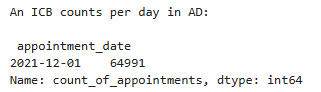

In [967]:
# # Compare counts per day with AD
# nc_E54000050 = nc.loc[
#                 (nc['icb_ons_code'].str.contains('E54000050')) &
#                 (nc['appointment_date'] >= '2021-12-01') &
#                 (nc['appointment_date'] < '2021-12-02')]\
#                 [['appointment_date', 'count_of_appointments']]

# nc_E54000050 = nc_E54000050.groupby(by=['appointment_date'])\
#                             ['count_of_appointments'].sum().sort_values(ascending=False)

# print("An ICB counts per day in NC:\n\n", nc_E54000050)

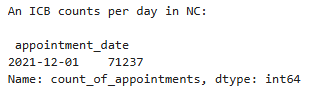

In [969]:
# Subset each category of appointments for even time frame
# Break down categories in separate subsets to speed up plotting

# AD - common period and subset of ICBs
ad_ss_icb = ad[['region_name', 'actual_duration', 
                'count_of_appointments']]

ad_ss_ad = ad_ss_icb.groupby(['actual_duration'])['count_of_appointments']\
                     .sum().sort_values(ascending=False).reset_index()

ad_ss_reg_ad = ad_ss_icb.groupby(['region_name','actual_duration'])['count_of_appointments']\
                        .sum().sort_values(ascending=False).reset_index()

In [970]:
# AR - common period and subset of ICBs
ar_ss_period = ar.loc[
    (ar['appointment_month'] >= '2021-12') &
    (ar['appointment_month'] <= '2022-06')]

ar_ss_icb = ar_ss_period[['appointment_month', 'icb_ons_code', 'appointment_status', 
                         'hcp_type', 'appointment_mode', 
                         'time_between_book_and_appointment', 
                         'count_of_appointments']]

In [971]:
# AR - common period and categories
ar_appstat = ar.loc[
    (ar['appointment_month'] >= '2021-12') &
    (ar['appointment_month'] <= '2022-06')][['appointment_month', 'appointment_status', 
                                             'count_of_appointments']]
ar_appstat = ar_appstat.groupby(by=['appointment_status'])['count_of_appointments']\
                       .sum().sort_values(ascending=False).reset_index()

# AR - hcp_type category
ar_hcp = ar.loc[
    (ar['appointment_month'] >= '2021-12') &
    (ar['appointment_month'] <= '2022-06')][['appointment_month', 'hcp_type', 
                                             'count_of_appointments']]
ar_hcp = ar_hcp.groupby(by=['hcp_type'])['count_of_appointments']\
               .sum().sort_values(ascending=False).reset_index()

# AR - appointment_mode category
ar_appmode = ar.loc[
    (ar['appointment_month'] >= '2021-12') &
    (ar['appointment_month'] <= '2022-06')][['appointment_month', 'appointment_mode', 
                                             'count_of_appointments']]
ar_appmode = ar_appmode.groupby(by=['appointment_mode'])['count_of_appointments']\
                       .sum().sort_values(ascending=False).reset_index()

# AR - time_between_book_and_appointment category
ar_btwn = ar.loc[
    (ar['appointment_month'] >= '2021-12') &
    (ar['appointment_month'] <= '2022-06')][['appointment_month', 
                                             'time_between_book_and_appointment', 
                                             'count_of_appointments']]
ar_btwn = ar_btwn.groupby(by=['time_between_book_and_appointment'])\
                            ['count_of_appointments']\
                 .sum().sort_values(ascending=False).reset_index()

In [972]:
# NC - common period and subset of ICBs
nc_ss_period = nc.loc[
    (nc['appointment_date'] >= '2021-12-01') &
    (nc['appointment_date'] <= '2022-06-30')]

nc_ss_icb = nc_ss_period[['appointment_month', 'icb_ons_code', 'service_setting', 
                         'context_type', 'national_category',
                         'count_of_appointments']]

In [973]:
# NC - common period and service_setting category
nc_sers = nc.loc[
    (nc['appointment_date'] >= '2021-12-01') &
    (nc['appointment_date'] <= '2022-06-30')][['appointment_month', 'service_setting', 
                                               'count_of_appointments']]
nc_sers = nc_sers.groupby(by=['service_setting'])['count_of_appointments']\
                 .sum().sort_values(ascending=False).reset_index()

# NC - context_type category
nc_contt = nc.loc[
    (nc['appointment_date'] >= '2021-12-01') &
    (nc['appointment_date'] <= '2022-06-30')][['appointment_month', 'context_type', 
                                               'count_of_appointments']]
nc_contt = nc_contt.groupby(by=['context_type'])['count_of_appointments']\
                   .sum().sort_values(ascending=False).reset_index()

# NC - national_category category
nc_natc = nc.loc[
    (nc['appointment_date'] >= '2021-12-01') &
    (nc['appointment_date'] <= '2022-06-30')][['appointment_month', 'national_category', 
                                               'count_of_appointments']]
nc_natc = nc_natc.groupby(by=['national_category'])['count_of_appointments']\
                 .sum().sort_values(ascending=False).reset_index()

In [974]:
# Compare total counts across three datasets
print(f"Number of appointments in AD (2021-12 - 2022-06): {(ad_ss_icb['count_of_appointments'].sum()):,}")
print(f"Number of appointments in AR (2021-12 - 2022-06): {(ar_ss_icb['count_of_appointments'].sum()):,}")
print(f"Number of appointments in NC (2021-12 - 2022-06): {(nc_ss_icb['count_of_appointments'].sum()):,}")

Number of appointments in AD (2021-12 - 2022-06): 167,980,692
Number of appointments in AR (2021-12 - 2022-06): 182,963,194
Number of appointments in NC (2021-12 - 2022-06): 182,963,194


In [975]:
# Compare with AR after dropping duplicates
ar_no_dup = ar.drop_duplicates()
ar_appstat_2 = ar_no_dup.loc[
    (ar['appointment_month'] >= '2021-12') &
    (ar['appointment_month'] <= '2022-06')][['appointment_month', 'appointment_status', 
                                             'count_of_appointments']]
ar_appstat_2 = ar_appstat_2.groupby(by=['appointment_status'])['count_of_appointments']\
                       .sum().sort_values(ascending=False).reset_index()

print(f"Number of appointments in AR (2021-12 - 2022-06): {(ar_appstat_2['count_of_appointments'].sum()):,}")

Number of appointments in AR (2021-12 - 2022-06): 182,889,972


## - Analyst's observations:

- Number of appoitments in AD for the same day and ICB differs from the rest of the datasets suggesting it can't be merged as it is not a relational data set.
- It it thus not possible to explore further into what categories are associated with poor duration data quality.
- Coinciding total in AR without cleaning for duplicates compared to NC where there are no dupicates proves those are not duplicated records. Decided not to exclude.

## TW -'tweets.csv' - explore data set

In [979]:
# Import and sense-check the twittes.csv data set as ad.
tw = pd.read_csv('tweets.csv')

print('tweets dataset:')
print(tw.shape)

# Determine the metadata, data types of the data set
tw.info()

tweets dataset:
(1174, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB


In [980]:
# 1.1 View the DataFrame.
# only 2 rows - for the sake of optimised memory usage
tw.head(2)

tweet_id  \
0  1567629223795527681   
1  1567582846612553728   

                                                                                                                                                                                           tweet_full_text  \
0  As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
1                                                              RT @AndreaGrammer: Work-life balance is at the foundation of how decisions are made and where #PremiseHealth is headed.  We're #hiring for…   

                                                                                                                                                                                            tweet_entities  \
0  {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
1  {'hashtags': [{'text': 'PremiseHealth', 'indices': [94, 108]}, {'text': 'hiring', 'indices': [127, 134]}], 'symbols': [], 'user_mentions': [{'screen_name': 'AndreaGrammer', 'name': 'Andrea Grammer...   

   tweet_entities_hashtags  \
0              #Healthcare   
1  #PremiseHealth, #hiring   

                                         tweet_metadata  tweet_retweet_count  \
0  {'iso_language_code': 'en', 'result_type': 'recent'}                    0   
1  {'iso_language_code': 'en', 'result_type': 'recent'}                    2   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en

In [981]:
# 1.2 View the DataFrame.
tw.tail(2)

tweet_id  \
1172  1567582892892782592   
1173  1567582846847533058   

                                                                                                                                                            tweet_full_text  \
1172  Happy physiotherapy 🩺 day 🎉..\n#bpt #physiotherapy \n#HealthyNation #healthcare \n#medicalcare \n#csjmu .\n@WHO \n@MoHFW_INDIA \n@nitish_0210 https://t.co/NQHdIoYymC   
1173                           RT @KimcoStaffing: Apply now to work for #MediQuestStaffing as EVS - #Hospital - 1st #shift -  Interviewing Now!! (#NewportBeach) #job http…   

                                                                                                                                                                                               tweet_entities  \
1172  {'hashtags': [{'text': 'bpt', 'indices': [30, 34]}, {'text': 'physiotherapy', 'indices': [35, 49]}, {'text': 'HealthyNation', 'indices': [51, 65]}, {'text': 'healthcare', 'indices': [66, 77]}, {'t...   
1173  {'hashtags': [{'text': 'MediQuestStaffing', 'indices': [41, 59]}, {'text': 'Hospital', 'indices': [69, 78]}, {'text': 'shift', 'indices': [85, 91]}, {'text': 'NewportBeach', 'indices': [115, 128]}...   

                                                      tweet_entities_hashtags  \
1172  #bpt, #physiotherapy, #HealthyNation, #healthcare, #medicalcare, #csjmu   
1173               #MediQuestStaffing, #Hospital, #shift, #NewportBeach, #job   

                                            tweet_metadata  \
1172  {'iso_language_code': 'en', 'result_type': 'recent'}   
1173  {'iso_language_code': 'en', 'result_type': 'recent'}   

      tweet_retweet_count  tweet_favorite_count  tweet_favorited  \
1172                    0                     5            False   
1173                    2                     0            False   

      tweet_retweeted tweet_lang  
1172            False         en  
1173            False         en

In [982]:
# Determine whether there are missing values.
columns_miss_count(tw)

tweet_entities_hashtags    167
dtype: int64

In [983]:
# Determine whether there are duplicated rows.
df_dup(tw)

'No duplicated rows'

In [984]:
# Determine the descriptive statistics of the data set.
# 1.1. for numeric data
tw.describe()

tweet_id  tweet_retweet_count  tweet_favorite_count
count                     1,174.00             1,174.00              1,174.00
mean  1,567,612,055,941,191,936.00                 8.63                  0.37
std          24,275,534,270,242.21                29.78                  2.04
min   1,567,574,368,858,914,816.00                 0.00                  0.00
25%   1,567,589,787,532,554,240.00                 0.00                  0.00
50%   1,567,611,203,412,713,472.00                 1.00                  0.00
75%   1,567,633,430,776,754,176.00                 3.00                  0.00
max   1,567,655,472,005,582,848.00               303.00                 42.00

In [985]:
# 1.2. include objects
tw.describe(include=['O'])

tweet_full_text  \
count                                                                                                                                           1174   
unique                                                                                                                                           961   
top     RT @khaleejtimes: .@BurjeelHoldings, a private healthcare services provider, has partnered with superstar @iamsrk as its new brand ambassad…   
freq                                                                                                                                              15   

                                                                                                                                                                                                 tweet_entities  \
count                                                                                                                                                                                                      1174   
unique                                                                                                                                                                                                      945   
top     {'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'khaleejtimes', 'name': 'Khaleej Times', 'id': 18860860, 'id_str': '18860860', 'indices': [3, 16]}, {'screen_name': 'BurjeelHoldin...   
freq                                                                                                                                                                                                         15   

       tweet_entities_hashtags  \
count                     1007   
unique                     710   
top                #healthcare   
freq                        88   

                                              tweet_metadata tweet_lang  
count                                                   1174       1174  
unique                                                     1          1  
top     {'iso_language_code': 'en', 'result_type': 'recent'}         en  
freq                                                    1174       1174

In [986]:
# Set figure size.
sns.set(rc={'figure.figsize':(15, 12)})

# Maximum column width to display
pd.options.display.max_colwidth = 200

In [987]:
# Would it be useful to only look at retweeted and favourite tweet messages?
# Explain your answer
tw_retweet_num = tw['tweet_retweet_count'].value_counts()
print("Number of Retweets:")
tw_retweet_num.head(10)

Number of Retweets:


tweet_retweet_count
0     526
1     215
2     114
3      70
5      35
4      27
7      18
12     16
8      15
73     14
Name: count, dtype: int64

In [988]:
tw_favorite_num = tw['tweet_favorite_count'].value_counts()
print("Number of Favorites:")
tw_favorite_num.head(10)

Number of Favorites:


tweet_favorite_count
0     1027
1       91
2       16
3       13
4        7
5        5
6        2
17       1
12       1
10       1
Name: count, dtype: int64

In [989]:
# Create a new DataFrame containing only the text.
tweets_text = tw.select_dtypes(include=['object']).copy()
print(len(tweets_text))
tweets_text = tweets_text[tweets_text['tweet_full_text'].str.contains('health')]
# View the DataFrame.
print(len(tweets_text))
tweets_text

1174
712


tweet_full_text  \
0     As Arkansas’ first Comprehensive Stroke Certified Center, UAMS provides Arkansans with access to the most advanced stoke care. Join us in our mission to make a difference in the health and well-be...   
3                                                                RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data…   
4     ICYMI: Our recent blogs on Cybersecurity in Accounting https://t.co/4nnK0FiVVL and Digital Transformation in Healthcare Finance https://t.co/jIqn52lHD3 are a great read, take a look!\n\n#blogs #di...   
5     Nursing interventions can be independent, dependent, or collaborative.\n-----\nLearn more: 👉 https://t.co/jrGQeqDme4\n.\n#firstcoastcna #cnaexam #cnaexampreparation #jacksonville #cnatraining #nur...   
6     🚨#NEW:🚨 Insurance companies are figuring out the best ways to collect information about members’ race and ethnicity data as focus intensifies on addressing #disparities. h/t @JessicaKimCohen &amp;...   
...                                                                                                                                                                                                       ...   
1167  @mkecounty Mental Health Emergency Center (24/7/365) officially opened in @cityofmilwaukee.  This is a beautiful example of #healthcare systems coming together &amp; committed to achieving #health...   
1168                                                             RT @khaleejtimes: .@BurjeelHoldings, a private healthcare services provider, has partnered with superstar @iamsrk as its new brand ambassad…   
1170  Not a cent towards workers who would like to advance their training, especially those already employed by SHA or who for various reasons cannot obtain a student loan. Half of our department applie...   
1171  The @hfmaorg Region 9 presents "The Value of ESG to the Healthcare Industry" and our own Kris Russell and Ron Present will be the key speakers. This #webinar will be taking place 9/13 and will exp...   
1172                                    Happy physiotherapy 🩺 day 🎉..\n#bpt #physiotherapy \n#HealthyNation #healthcare \n#medicalcare \n#csjmu .\n@WHO \n@MoHFW_INDIA \n@nitish_0210 https://t.co/NQHdIoYymC   

                                                                                                                                                                                               tweet_entities  \
0     {'hashtags': [{'text': 'Healthcare', 'indices': [253, 264]}], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/yw0cstfmSI', 'expanded_url': 'https://bit.ly/3BiSKbs', 'display_url...   
3     {'hashtags': [{'text': 'NEW', 'indices': [20, 24]}], 'symbols': [], 'user_mentions': [{'screen_name': 'modrnhealthcr', 'name': 'Modern Healthcare', 'id': 18935711, 'id_str': '18935711', 'indices':...   
4     {'hashtags': [{'text': 'blogs', 'indices': [184, 190]}, {'text': 'digitaltransformation', 'indices': [191, 213]}, {'text': 'cybersecurity', 'indices': [214, 228]}, {'text': 'accounting', 'indices'...   
5     {'hashtags': [{'text': 'firstcoastcna', 'indices': [117, 131]}, {'text': 'cnaexam', 'indices': [132, 140]}, {'text': 'cnaexampreparation', 'indices': [141, 160]}, {'text': 'jacksonville', 'indices...   
6     {'hashtags': [{'text': 'NEW', 'indices': [1, 5]}, {'text': 'disparities', 'indices': [156, 168]}, {'text': 'healthcare', 'indices': [211, 222]}, {'text': 'alert', 'indices': [223, 229]}, {'text': ...   
...                                                                                                                                                                                                       ...   
1167  {'hashtags': [{'text': 'healthcare', 'indices': [124, 135]}, {'text': 'healthequity', 'indices': [189, 202]}], 'symbols': [], 'user_mentions': [{'screen_name': 'mkecounty', 'name': 'Milwaukee Coun...   
1168  {'h

In [990]:
# Use a for loop, and specify the iterator_variable and the sequence
tags = []

for y in [x.split(' ') for x in tw['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())

In [991]:
# Create a Pandas Series to count the values in the list. 
# Display the first 30 records.

tags_series = pd.Series(tags).value_counts()
tags_series.head(30)

#healthcare                    716
#health                         80
#medicine                       41
#ai                             40
#job                            38
#medical                        35
#strategy                       30
#pharmaceutical                 28
#digitalhealth                  25
#pharma                         25
#marketing                      25
#medtwitter                     24
#biotech                        24
#competitiveintelligence        24
#meded                          23
#vaccine                        18
#hiring                         18
#news                           17
#machinelearning                17
#technology                     17
#coronavirus                    16
#womeninmedicine                16
#covid                          16
#competitivemarketing           16
#wellness                       15
#healthtech                     15
#doctorofveterinarymedicine     14
#science                        14
#medicare           

In [992]:
# Convert the series to a DataFrame in preparation for visualisation.
hashtag = pd.DataFrame(tags_series).reset_index()

# Rename the columns.
hashtag.columns = ['word', 'count']
hashtag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    1754 non-null   object
 1   count   1754 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.5+ KB


In [993]:
# Fix the count datatype.
hashtag['count'] = hashtag['count'].astype('int')

# View the result.
hashtag['count'].dtype

dtype('int32')

In [994]:
# Sense-check df
hashtag.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    1754 non-null   object
 1   count   1754 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 20.7+ KB


In [995]:
# Display records where the count is larger than 10.
hashtag_sub_overten = hashtag[hashtag['count'] > 10]
print(len(hashtag_sub_overten))
hashtag_sub_overten.head(10)

47


word  count
0      #healthcare    716
1          #health     80
2        #medicine     41
3              #ai     40
4             #job     38
5         #medical     35
6        #strategy     30
7  #pharmaceutical     28
8   #digitalhealth     25
9          #pharma     25

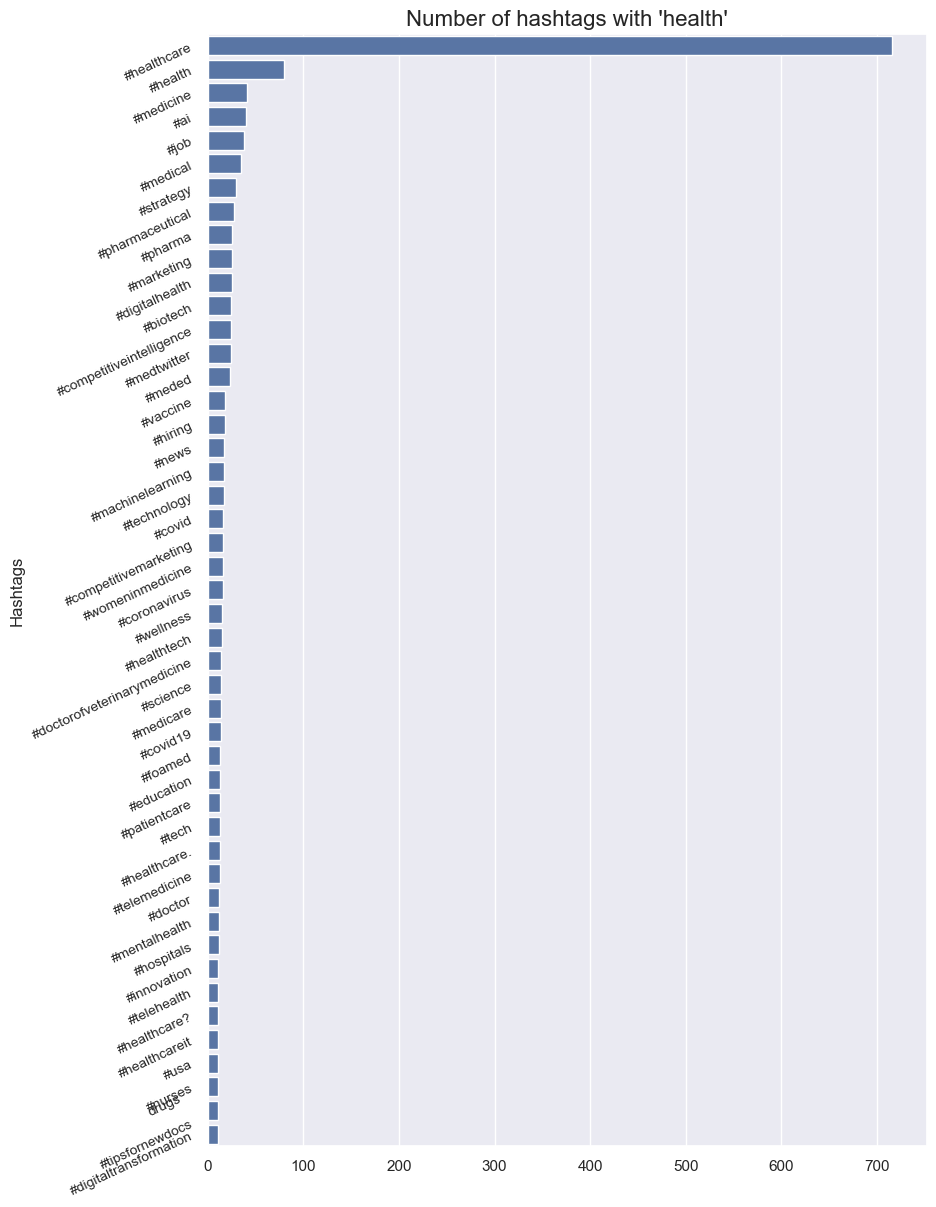

In [996]:
# Create a Seaborn barplot indicating records with a count >10 records.
plt.figure(figsize=(8, 12))
plt.title("Number of hashtags with 'health'", fontsize=16)

plt.tight_layout() # fixes overlapping titles

sns.barplot(x='count', y='word',
            data=hashtag_sub_overten.sort_values(by='count', ascending=False))
plt.xlabel("", fontsize=1)
plt.ylabel("Hashtags", fontsize=12)
plt.yticks(rotation=25, fontsize=10) # fixes overlapping ticks
plt.show()

In [997]:
# Filter out health related 
hashtag_wo_health = hashtag_sub_overten[hashtag_sub_overten['word']\
                        .str.contains('health')==False]\
                        .reset_index()

print(len(hashtag_wo_health))
hashtag_wo_health.head(5)

38


index       word  count
0      2  #medicine     41
1      3        #ai     40
2      4       #job     38
3      5   #medical     35
4      6  #strategy     30

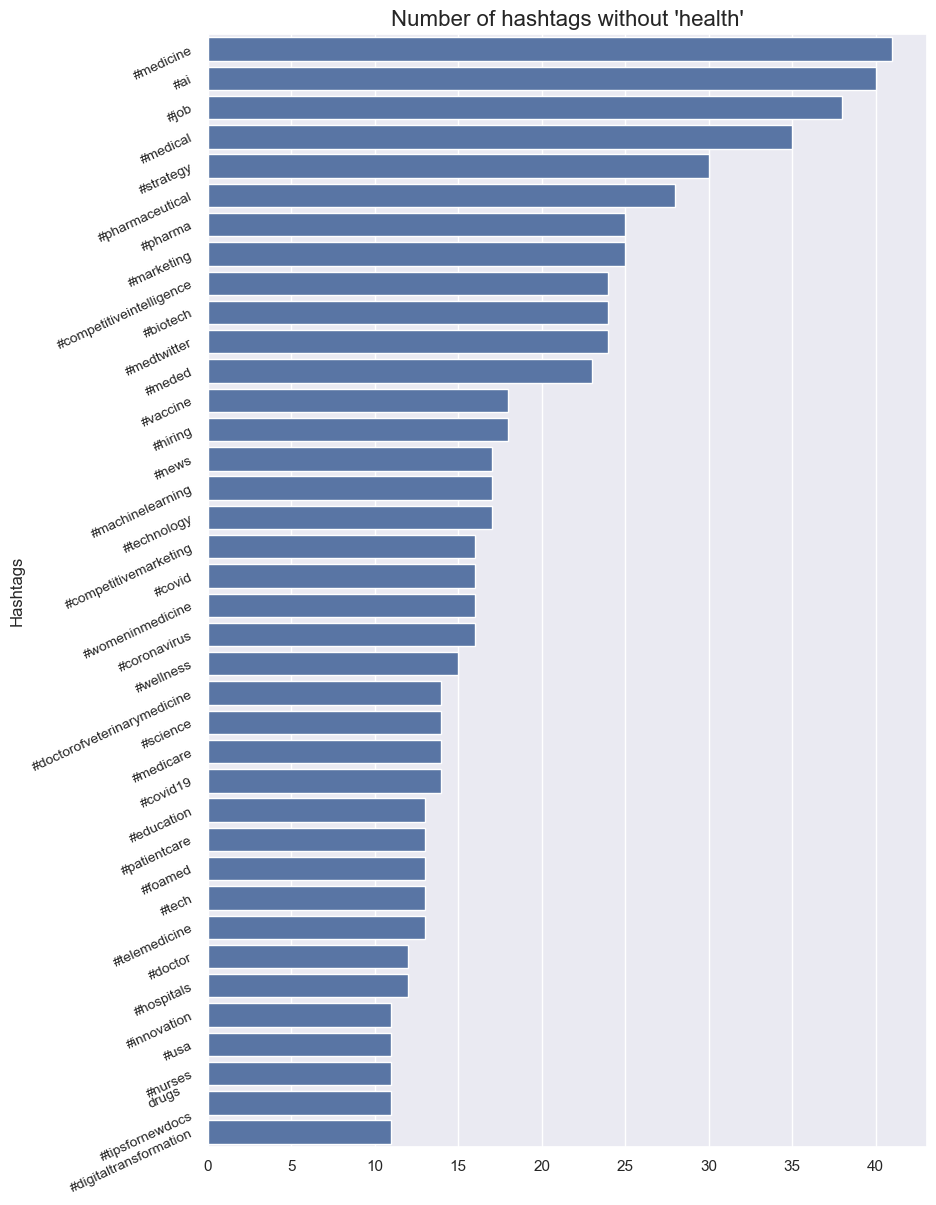

In [998]:
# Create a Seaborn barplot indicating records with a count >10 records without 'health'
plt.figure(figsize=(8, 12))
plt.title("Number of hashtags without 'health'", fontsize=16)

plt.tight_layout() # fixes overlapping titles

sns.barplot(x='count', y='word',
            data=hashtag_wo_health.sort_values(by='count', ascending=False))
plt.xlabel("", fontsize=1)
plt.ylabel("Hashtags", fontsize=12)
plt.yticks(rotation=25, fontsize=10)
plt.show()

## - Analyst's observations:

<p>
    <ul>
        <li>not all data makes sense as some 'tweet_retweet_count' correspond to 'False' in 'tweet_retweeted' column</li>
        <li>smaller unique 'tweet_full_text' along with no duplicates rows suggests some context got retweeted by other users: 63% of tweets were either not retweeted or only once ((526+215)/1174); 88% of tweets have no favorites (1027/1174)</li>
        <li>thus data is of minimun interest, nevertheless explore further as #healthcare 'tweet_entities_hashtags' appears often</li>
        <li>712 out of 1174 tweets are related to health but the proportion of positive vs negative is not definitive from the content, this limits its use for the business objective</li>
        <li>NHS could potentially use the data: 
            <ol>
                <li>to track comments related to waiting time to monitor the level of satisfaction with the services - low level combined with high number of long waiting time related comments and statistics would indicate the need to reassess services availability</li>
                 <li>occasionally publish statistics on missed appointments and its influence on the budget to inform the public and address the issue</li>
            </ol>
        </li>
        <li>Suggestions to improve visualisations - split hashtag figures in two subfigures: related (see below) vs not related (already done) to 'health':</li>
    </ul>
</p>

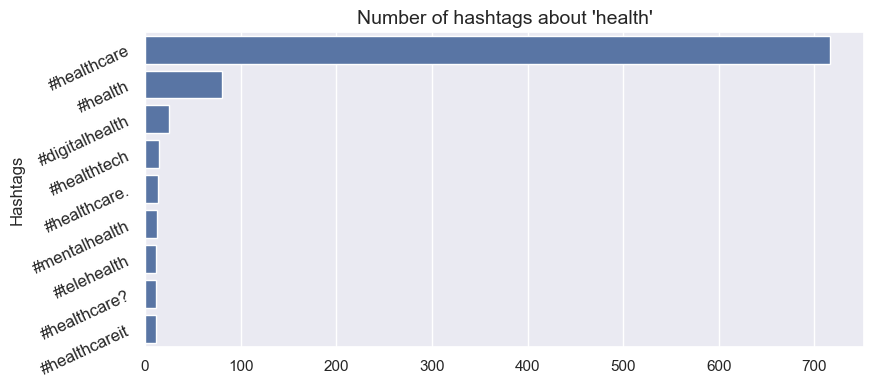

In [1001]:
# Create data set associated with 'health'
hashtag_w_health = hashtag_sub_overten[hashtag_sub_overten['word']\
                        .str.contains('health')==True]\
                        .reset_index()

# Create a Seaborn barplot indicating records with a count >10 records without 'health'
plt.figure(figsize=(8, 4))
plt.title("Number of hashtags about 'health'", fontsize=14)

plt.tight_layout() # fixes overlapping titles

sns.barplot(x='count', y='word',
            data=hashtag_w_health.sort_values(by='count', ascending=False))
plt.xlabel("", fontsize=1)
plt.ylabel("Hashtags", fontsize=12)
plt.yticks(rotation=25, fontsize=12)
plt.show()

# Exploratory analysis continued

## Analysed time frame

In [1004]:
# Calculate the dates ranges for each data set through min and max

# Make sure is printed without timestamp
print(
f"""AD dates  date dtype {ad['appointment_date'].dtype}
AR months date dtype {ar['appointment_month'].dtype}
NC dates  date dtype {nc['appointment_date'].dtype}
NC months date dtype {nc['appointment_month'].dtype}
"""
)

# Eliminate timestamp
ad['appointment_date'] = ad['appointment_date'].astype(str)
nc['appointment_date'] = nc['appointment_date'].astype(str)

# Calculate the dates ranges for each data set through min and max
ad_date_min = ad['appointment_date'].min()
ad_date_max = ad['appointment_date'].max()

ar_month_min = ar['appointment_month'].min()
ar_month_max = ar['appointment_month'].max()

nc_date_min = nc['appointment_date'].min()
nc_date_max = nc['appointment_date'].max()

nc_month_min = nc['appointment_month'].min()
nc_month_max = nc['appointment_month'].max()

print(
f"""AD dates  range between {ad_date_min}  -  {ad_date_max}
AR months range between {ar_month_min}     -  {ar_month_max}
NC dates  range between {nc_date_min}  -  {nc_date_max}
NC months range between {nc_month_min}     -  {nc_month_max}
Common time frame is:   {ad_date_min}  -  {nc_date_max}"""
    )

AD dates  date dtype datetime64[ns]
AR months date dtype period[M]
NC dates  date dtype datetime64[ns]
NC months date dtype period[M]

AD dates  range between 2021-12-01  -  2022-06-30
AR months range between 2020-01     -  2022-06
NC dates  range between 2021-08-01  -  2022-06-30
NC months range between 2021-08     -  2022-06
Common time frame is:   2021-12-01  -  2022-06-30


## Represented categories

#### ----->ad_fig

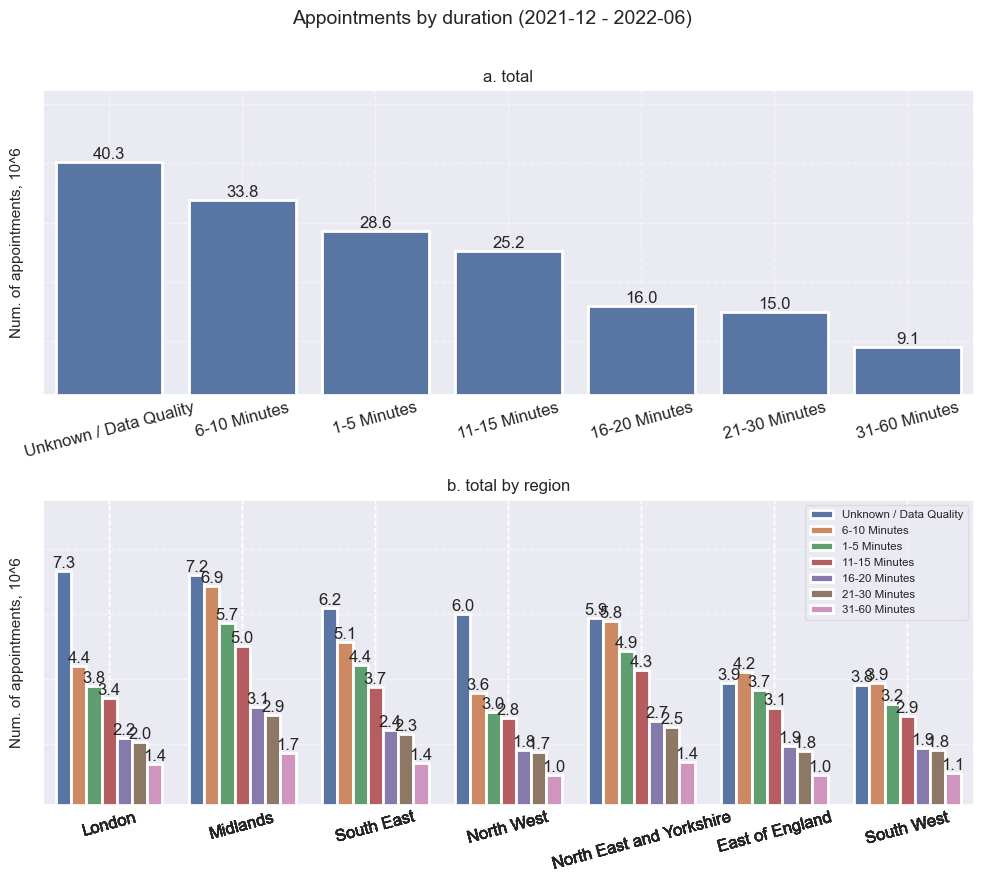

In [1007]:
# Plot duration
ad_fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ad_fig.suptitle('Appointments by duration (2021-12 - 2022-06)', fontsize=14, y=1.1)

# total by duration
barplot_in_array(data=ad_ss_ad,
                 work_axis=ax[0],
                 avgcapacity=False,
                 categ_col='actual_duration', 
                 value_col='count_of_appointments', 
                 subtitle="a. total", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)

# duration by region
barplot_in_array(data=ad_ss_reg_ad,
                 work_axis=ax[1],
                 avgcapacity=False,
                 categ_col='region_name', 
                 value_col='count_of_appointments', 
                 subtitle="b. total by region", 
                 ylabel="Num. of appointments, 10^6",
                 legend=True,
                 hue='actual_duration')

ad_fig.tight_layout(h_pad=0.5) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.1) # fixes overlapping titles
ad_fig.show()

In [1008]:
# % share of appointments by duration in total
ad_ss_ad = ad_ss_ad.assign(total_share=lambda x: (x['count_of_appointments']\
                                                    / x['count_of_appointments'].sum()))

ad_ss_ad.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

actual_duration count_of_appointments  total_share
0  Unknown / Data Quality            40,284,086         0.24
1            6-10 Minutes            33,800,815         0.20
2             1-5 Minutes            28,600,865         0.17
3           11-15 Minutes            25,160,882         0.15
4           16-20 Minutes            16,004,247         0.10
5           21-30 Minutes            15,026,365         0.09
6           31-60 Minutes             9,103,432         0.05

#### ----->ar_fig

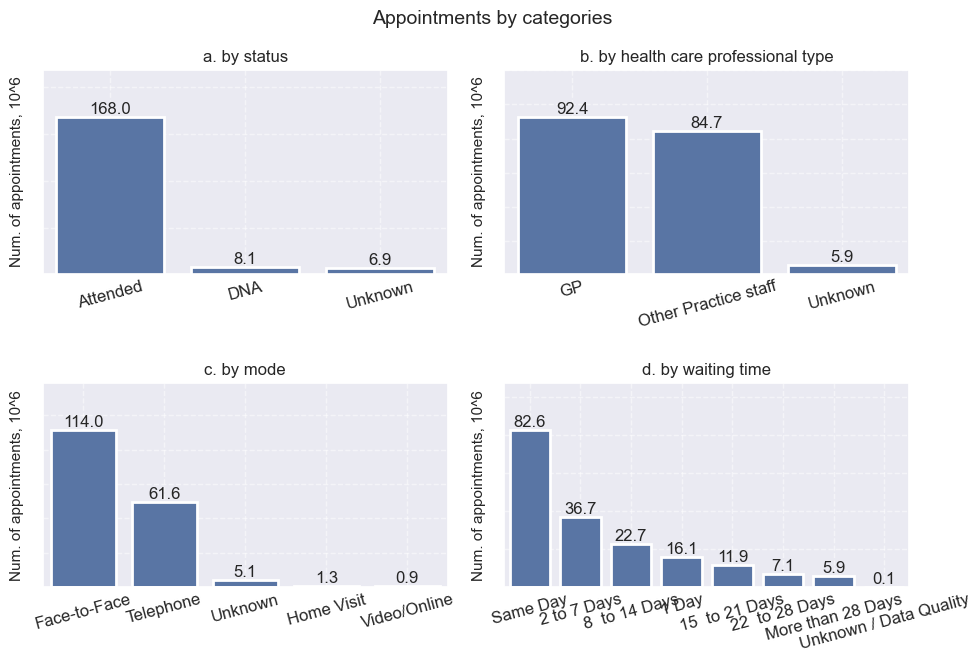

In [1010]:
# Plot appointments categories
ar_fig, ax = plt.subplots(2, 2, figsize=(10, 6))
ar_fig.suptitle('Appointments by categories', fontsize=14, y=1.1)

# a.
barplot_in_array(data=ar_appstat,
                 work_axis=ax[0,0],
                 avgcapacity=False,
                 categ_col='appointment_status', 
                 value_col='count_of_appointments', 
                 subtitle="a. by status", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)

# b.
barplot_in_array(data=ar_hcp,
                 work_axis=ax[0,1],
                 avgcapacity=False,
                 categ_col='hcp_type', 
                 value_col='count_of_appointments', 
                 subtitle="b. by health care professional type", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)

# c.
barplot_in_array(data=ar_appmode,
                 work_axis=ax[1,0],
                 avgcapacity=False,
                 categ_col='appointment_mode', 
                 value_col='count_of_appointments', 
                 subtitle="c. by mode", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)

# d.
barplot_in_array(data=ar_btwn,
                 work_axis=ax[1,1],
                 avgcapacity=False,
                 categ_col='time_between_book_and_appointment', 
                 value_col='count_of_appointments', 
                 subtitle="d. by waiting time", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)

ar_fig.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ar_fig.show()

In [1011]:
# % of appointments statuses in total
ar_appstat = ar_appstat.assign(total_share=lambda x: (x['count_of_appointments']\
                                                    / x['count_of_appointments'].sum()))

ar_appstat.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

appointment_status count_of_appointments  total_share
0           Attended           167,980,692         0.92
1                DNA             8,054,188         0.04
2            Unknown             6,928,314         0.04

In [1012]:
# % of appointments by hcp in total
ar_hcp = ar_hcp.assign(total_share=lambda x: (x['count_of_appointments']\
                                            / x['count_of_appointments'].sum()))

ar_hcp.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

hcp_type count_of_appointments  total_share
0                    GP            92,386,135         0.50
1  Other Practice staff            84,682,917         0.46
2               Unknown             5,894,142         0.03

In [1013]:
# % of appointments modes in total
ar_appmode = ar_appmode.assign(total_share=lambda x: (x['count_of_appointments']\
                                                    / x['count_of_appointments'].sum()))

ar_appmode.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

appointment_mode count_of_appointments  total_share
0     Face-to-Face           114,016,772         0.62
1        Telephone            61,613,653         0.34
2          Unknown             5,103,949         0.03
3       Home Visit             1,285,751         0.01
4     Video/Online               943,069         0.01

In [1014]:
# % of appointments by waiting time in total
ar_btwn = ar_btwn.assign(total_share=lambda x: (x['count_of_appointments']\
                                              / x['count_of_appointments'].sum()))

ar_btwn.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

time_between_book_and_appointment count_of_appointments  total_share
0                          Same Day            82,554,607         0.45
1                       2 to 7 Days            36,707,478         0.20
2                     8  to 14 Days            22,684,786         0.12
3                             1 Day            16,083,535         0.09
4                    15  to 21 Days            11,871,816         0.06
5                    22  to 28 Days             7,067,239         0.04
6                 More than 28 Days             5,868,098         0.03
7            Unknown / Data Quality               125,635         0.00

#### ----->nc_fig

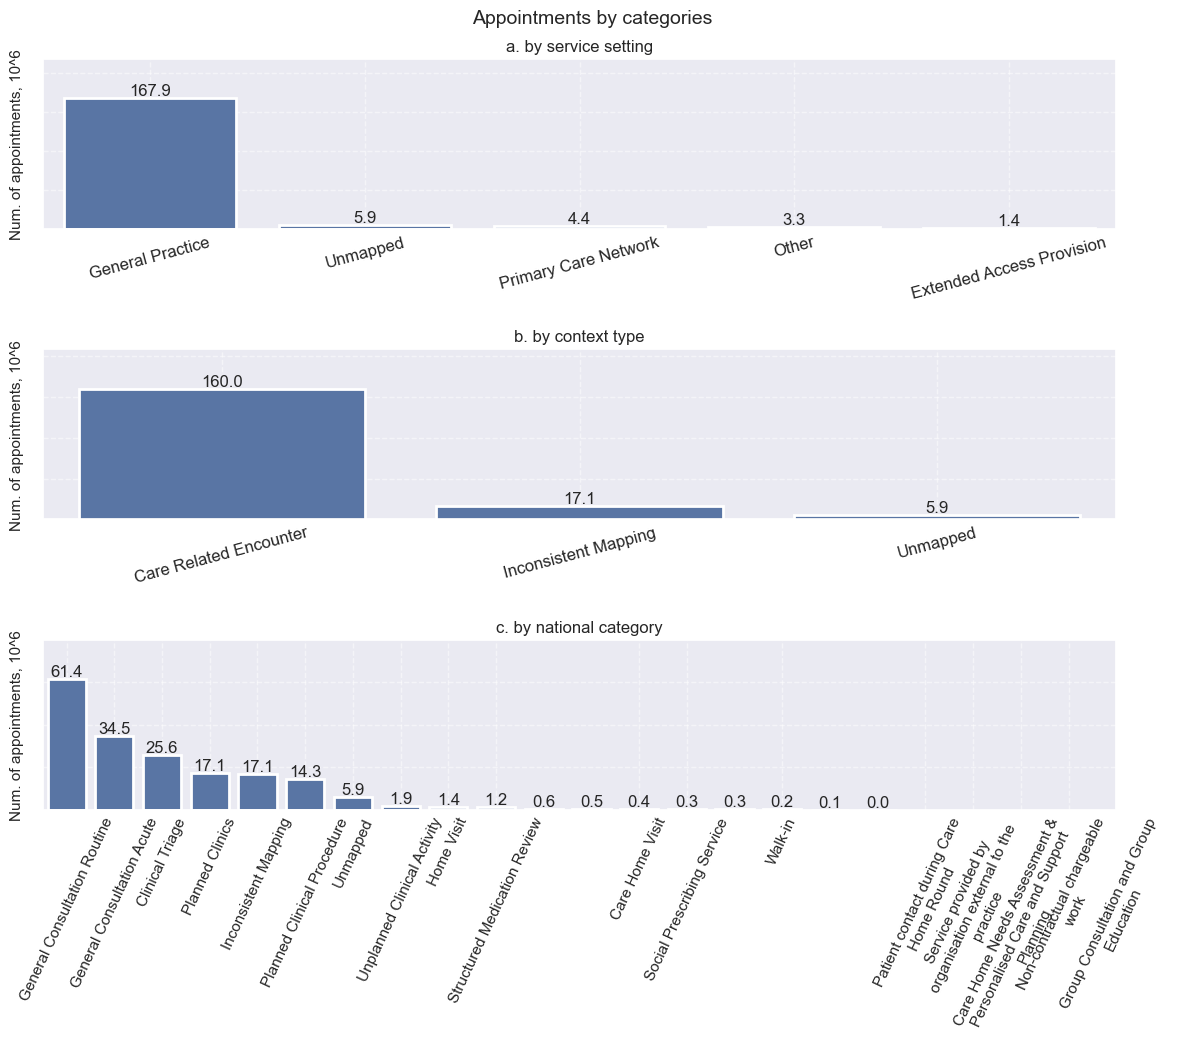

In [1016]:
# Plot appointments categories
nc_fig, ax = plt.subplots(3, 1, figsize=(12, 10))
nc_fig.suptitle('Appointments by categories', fontsize=14, y=1.05)

# a.
barplot_in_array(data=nc_sers,
                 work_axis=ax[0],
                 avgcapacity=False,
                 categ_col='service_setting', 
                 value_col='count_of_appointments', 
                 subtitle="a. by service setting", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)

# b.
barplot_in_array(data=nc_contt,
                 work_axis=ax[1],
                 avgcapacity=False,
                 categ_col='context_type', 
                 value_col='count_of_appointments', 
                 subtitle="b. by context type", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)

# c.
barplot_in_array(data=nc_natc,
                 work_axis=ax[2],
                 avgcapacity=False,
                 categ_col='national_category', 
                 value_col='count_of_appointments', 
                 subtitle="c. by national category", 
                 ylabel="Num. of appointments, 10^6",
                 legend=False)
ax[2].tick_params(axis='x', labelrotation=65, labelsize=11, 
                          length=40, direction='in')

nc_fig.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
nc_fig.show()

In [1017]:
# % of appointments by waiting time in total
nc_sers = nc_sers.assign(total_share=lambda x: (x['count_of_appointments']\
                                              / x['count_of_appointments'].sum()))

nc_sers.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

service_setting count_of_appointments  total_share
0           General Practice           167,920,958         0.92
1                   Unmapped             5,887,700         0.03
2       Primary Care Network             4,415,148         0.02
3                      Other             3,328,530         0.02
4  Extended Access Provision             1,410,858         0.01

In [1018]:
# % of appointments by waiting time in total
nc_contt = nc_contt.assign(total_share=lambda x: (x['count_of_appointments']\
                                              / x['count_of_appointments'].sum()))

nc_contt.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

context_type count_of_appointments  total_share
0  Care Related Encounter           160,007,693         0.87
1    Inconsistent Mapping            17,067,801         0.09
2                Unmapped             5,887,700         0.03

In [1019]:
# % of appointments by waiting time in total
nc_natc = nc_natc.assign(total_share=lambda x: (x['count_of_appointments']\
                                              / x['count_of_appointments'].sum()))

nc_natc.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

national_category  \
0                                          General Consultation Routine   
1                                            General Consultation Acute   
2                                                       Clinical Triage   
3                                                       Planned Clinics   
4                                                  Inconsistent Mapping   
5                                            Planned Clinical Procedure   
6                                                              Unmapped   
7                                           Unplanned Clinical Activity   
8                                                            Home Visit   
9                                          Structured Medication Review   
10                               Patient contact during Care Home Round   
11            Service provided by organisation external to the practice   
12                                                      Care Home Visit   
13                                           Social Prescribing Service   
14  Care Home Needs Assessment & Personalised Care and Support Planning   
15                                                              Walk-in   
16                                      Non-contractual chargeable work   
17                               Group Consultation and Group Education   

   count_of_appointments  total_share  
0             61,419,764         0.34  
1             34,466,994         0.19  
2             25,568,097         0.14  
3             17,105,825         0.09  
4             17,067,801         0.09  
5             14,339,997         0.08  
6              5,887,700         0.03  
7              1,943,489         0.01  
8              1,365,406         0.01  
9              1,227,033         0.01  
10               641,365         0.00  
11               547,716         0.00  
12               411,648         0.00  
13               329,585         0.00  
14               271,457         0.00  
15               243,049         0.00  
16                88,124         0.00  
17                38,144         0.00

# - Analyst's observations:

**AR**:

- 92% of appointments were attended (over 167 million), 
- 50% are with GP and 46% with other practice staff, 
- 62% were face-to-face and 34% over the phone, 
- 42% on the same day and 20% within 2-7 days since scheduling.

**NC**:
- 91% of appointments are with GP,
- 87% of appointments are Care Related Encounter,
- 34% of appointments are General Consultation Routine, 19% - General Consultation Acute, 14% - Clinical Triage.

**AD** (2021-12 - 2022-06): 
- "The Royal College of General Practitioners (RCGP) recommends that GP appointments in the UK should be at least 15 minutes long. However, many practices still offer 10-minute appointments" [(bmj)](https://www.bmj.com/content/365/bmj.l2389#:~:text=GP%20appointments%20in%20the%20UK,that%20I%20usually%20run%20late.), [(NHS England)](https://www.england.nhs.uk/gp/case-studies/600-gp-hours-released-a-year-after-reducing-inappropriate-appointments-chiswick-health-practice-london/#:~:text=Most%20of%20the%20GPs%20have,Impact)
- 37% of appointments take from 1-10 minutes,
- only 25% take 11-20 minutes,
- 24% are not market and could equally last 0 - over 60 minutes.

#  Explanatory analysis: Has there been adequate staff and capacity in the networks?

## Categorical time series analysis

### Highest month

In [1025]:
# For each of these service settings, determine the number of records available 
# for the period and the location. 

nc['appointment_date'] = pd.to_datetime(nc['appointment_date'])

nc_serviceseting_half = nc.loc[
    (nc['sub_icb_location_name'] == "NHS North West London ICB - W2U3Z") &
    (nc['appointment_date'] >= '2022-01-01') &
    (nc['appointment_date'] <= '2022-06-01')
][[
        'sub_icb_location_name',
        'appointment_date',
        'service_setting',
        'count_of_appointments']]

# View the subset

nc_serviceseting_half = nc_serviceseting_half.groupby('service_setting')['count_of_appointments'] \
                                    .sum().sort_values(ascending=False)

nc_serviceseting_half = nc_serviceseting_half.apply(format_numbers)

nc_serviceseting_half

service_setting
General Practice             4,804,239
Unmapped                       391,106
Other                          152,897
Primary Care Network           109,840
Extended Access Provision       98,159
Name: count_of_appointments, dtype: object

There are multiple options to identify a month that had the highest number of appointments

In [1027]:
# AD aggregate appointments by month and sort (each data set)

ad['appointment_date'] = pd.to_datetime(ad['appointment_date'])     # set date type
ad['year'] = ad['appointment_date'].dt.year    # extract year
ad['month'] = ad['appointment_date'].dt.month      # extract year

ad_highestmonth = ad.groupby(['year','month'])['count_of_appointments'].sum().sort_values(ascending=False)
ad_highestmonth.apply(format_numbers)

year  month
2022  3        27,170,002
      5        25,343,941
      6        23,715,317
      1        23,597,196
      2        23,351,939
2021  12       22,853,483
2022  4        21,948,814
Name: count_of_appointments, dtype: object

In [1028]:
# AR aggregate appointments by month and sort
ar_highestmonth = ar.groupby('appointment_month')['count_of_appointments'].sum().sort_values(ascending=False)
ar_highestmonth.apply(format_numbers)

appointment_month
2021-11    30,405,070
2021-10    30,303,834
2022-03    29,595,038
2021-09    28,522,501
2020-10    28,301,932
2022-05    27,495,508
2021-03    27,225,424
2020-01    27,199,296
2021-06    26,784,182
2020-09    26,714,255
2022-06    25,828,078
2021-07    25,739,219
2022-01    25,635,474
2022-02    25,355,260
2021-12    25,140,776
2020-11    25,061,602
2020-02    24,104,621
2020-03    24,053,468
2022-04    23,913,060
2021-04    23,879,932
2021-08    23,852,171
2020-12    23,535,936
2021-05    23,508,395
2021-01    22,492,069
2020-07    22,491,437
2021-02    22,399,569
2020-06    20,690,805
2020-08    20,150,520
2020-05    16,417,212
2020-04    16,007,881
Freq: M, Name: count_of_appointments, dtype: object

In [1029]:
# Alternative: AR aggregate appointments by month and sort
# ar['appointment_month'] = ar['appointment_month'].astype(str)
# ar['appointment_month'] = pd.to_datetime(ar['appointment_month'])
ar['year'] = ar['appointment_month'].dt.year    # extract year
ar['month'] = ar['appointment_month'].dt.month      # extract month

ar_highestmonth = ar.groupby(['year','month'])['count_of_appointments'].sum().sort_values(ascending=False)
ar_highestmonth.apply(format_numbers)

year  month
2021  11       30,405,070
      10       30,303,834
2022  3        29,595,038
2021  9        28,522,501
2020  10       28,301,932
2022  5        27,495,508
2021  3        27,225,424
2020  1        27,199,296
2021  6        26,784,182
2020  9        26,714,255
2022  6        25,828,078
2021  7        25,739,219
2022  1        25,635,474
      2        25,355,260
2021  12       25,140,776
2020  11       25,061,602
      2        24,104,621
      3        24,053,468
2022  4        23,913,060
2021  4        23,879,932
      8        23,852,171
2020  12       23,535,936
2021  5        23,508,395
      1        22,492,069
2020  7        22,491,437
2021  2        22,399,569
2020  6        20,690,805
      8        20,150,520
      5        16,417,212
      4        16,007,881
Name: count_of_appointments, dtype: object

In [1030]:
# NC aggregate appointments by month and sort

nc_highestmonth = nc.groupby('appointment_month')['count_of_appointments'].sum().sort_values(ascending=False)
nc_highestmonth.apply(format_numbers)

appointment_month
2021-11    30,405,070
2021-10    30,303,834
2022-03    29,595,038
2021-09    28,522,501
2022-05    27,495,508
2022-06    25,828,078
2022-01    25,635,474
2022-02    25,355,260
2021-12    25,140,776
2022-04    23,913,060
2021-08    23,852,171
Freq: M, Name: count_of_appointments, dtype: object

In [1031]:
# Alternative: NC aggregate appointments by month and sort

nc['appointment_date'] = pd.to_datetime(nc['appointment_date'])     # set date type
nc['year'] = nc['appointment_date'].dt.year    # extract year
nc['month'] = nc['appointment_date'].dt.month      # extract month

nc_highestmonth = nc.groupby(['year','month'])['count_of_appointments'].sum().sort_values(ascending=False)
nc_highestmonth.apply(format_numbers)

year  month
2021  11       30,405,070
      10       30,303,834
2022  3        29,595,038
2021  9        28,522,501
2022  5        27,495,508
      6        25,828,078
      1        25,635,474
      2        25,355,260
2021  12       25,140,776
2022  4        23,913,060
2021  8        23,852,171
Name: count_of_appointments, dtype: object

### AD over time, outliers

In [1033]:
# subset AD and group by year and month
ad_ad_monthly = ad.groupby(['year', 'month', 'appointment_date', 'actual_duration']) \
                  .agg({'count_of_appointments': 'sum'}).reset_index()            

# View output.
# print(ad_ad_monthly.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x))

ad_ad_monthly['appointment_date'] = pd.to_datetime(ad_ad_monthly['appointment_date']).dt.date

#### ----->ad_fig_distribution_outliers

In [1035]:
# Combine 'year' and 'month' in one column and calculate monthly and daily totals and avg. by region
ad['appointment_month'] = pd.to_datetime(ad[['year', 'month']].assign(day=1)).dt.date

ad_ss_month_date_reg = ad[['appointment_month', 'appointment_date', 'region_name', 'count_of_appointments']]

ad_ss_monthly_reg = ad_ss_month_date_reg.groupby(['appointment_month', 'region_name'])\
                                                 ['count_of_appointments'].sum().reset_index()

ad_ss_daily_reg = ad_ss_month_date_reg.groupby(['appointment_date', 'region_name'])\
                                               ['count_of_appointments'].sum().reset_index()

ad_ss_monthly_avg_reg = ad_ss_month_date_reg.groupby(['appointment_month', 'region_name'])\
                                                     ['count_of_appointments'].mean().reset_index()

ad_ss_daily_avg_reg = ad_ss_month_date_reg.groupby(['appointment_date', 'region_name'])\
                                                   ['count_of_appointments'].mean().reset_index()

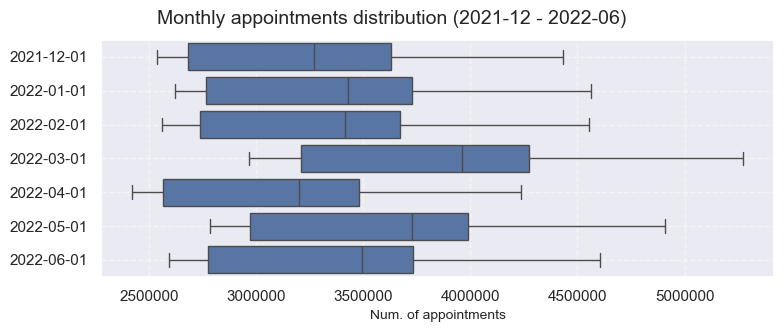

In [1036]:
# Plot monthly appointments distribution
ad_fig_monthly_distribution_outliers, ax = plt.subplots(1, 1, figsize=(8, 3))
ad_fig_monthly_distribution_outliers.suptitle('Monthly appointments distribution (2021-12 - 2022-06)', fontsize=14, y=1.1)

sns.boxplot(data=ad_ss_monthly_reg,
            y='appointment_month', x='count_of_appointments', 
            ax=ax, linewidth=1)
ax.yaxis.set_label_text(None) # it is obvious from plot title
ax.xaxis.set_label_text("Num. of appointments", fontsize=10)
ax.ticklabel_format(axis='x', style='plain') 
ax.grid(True, linestyle="--", alpha=0.5)

ad_fig_monthly_distribution_outliers.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ad_fig_monthly_distribution_outliers.show()

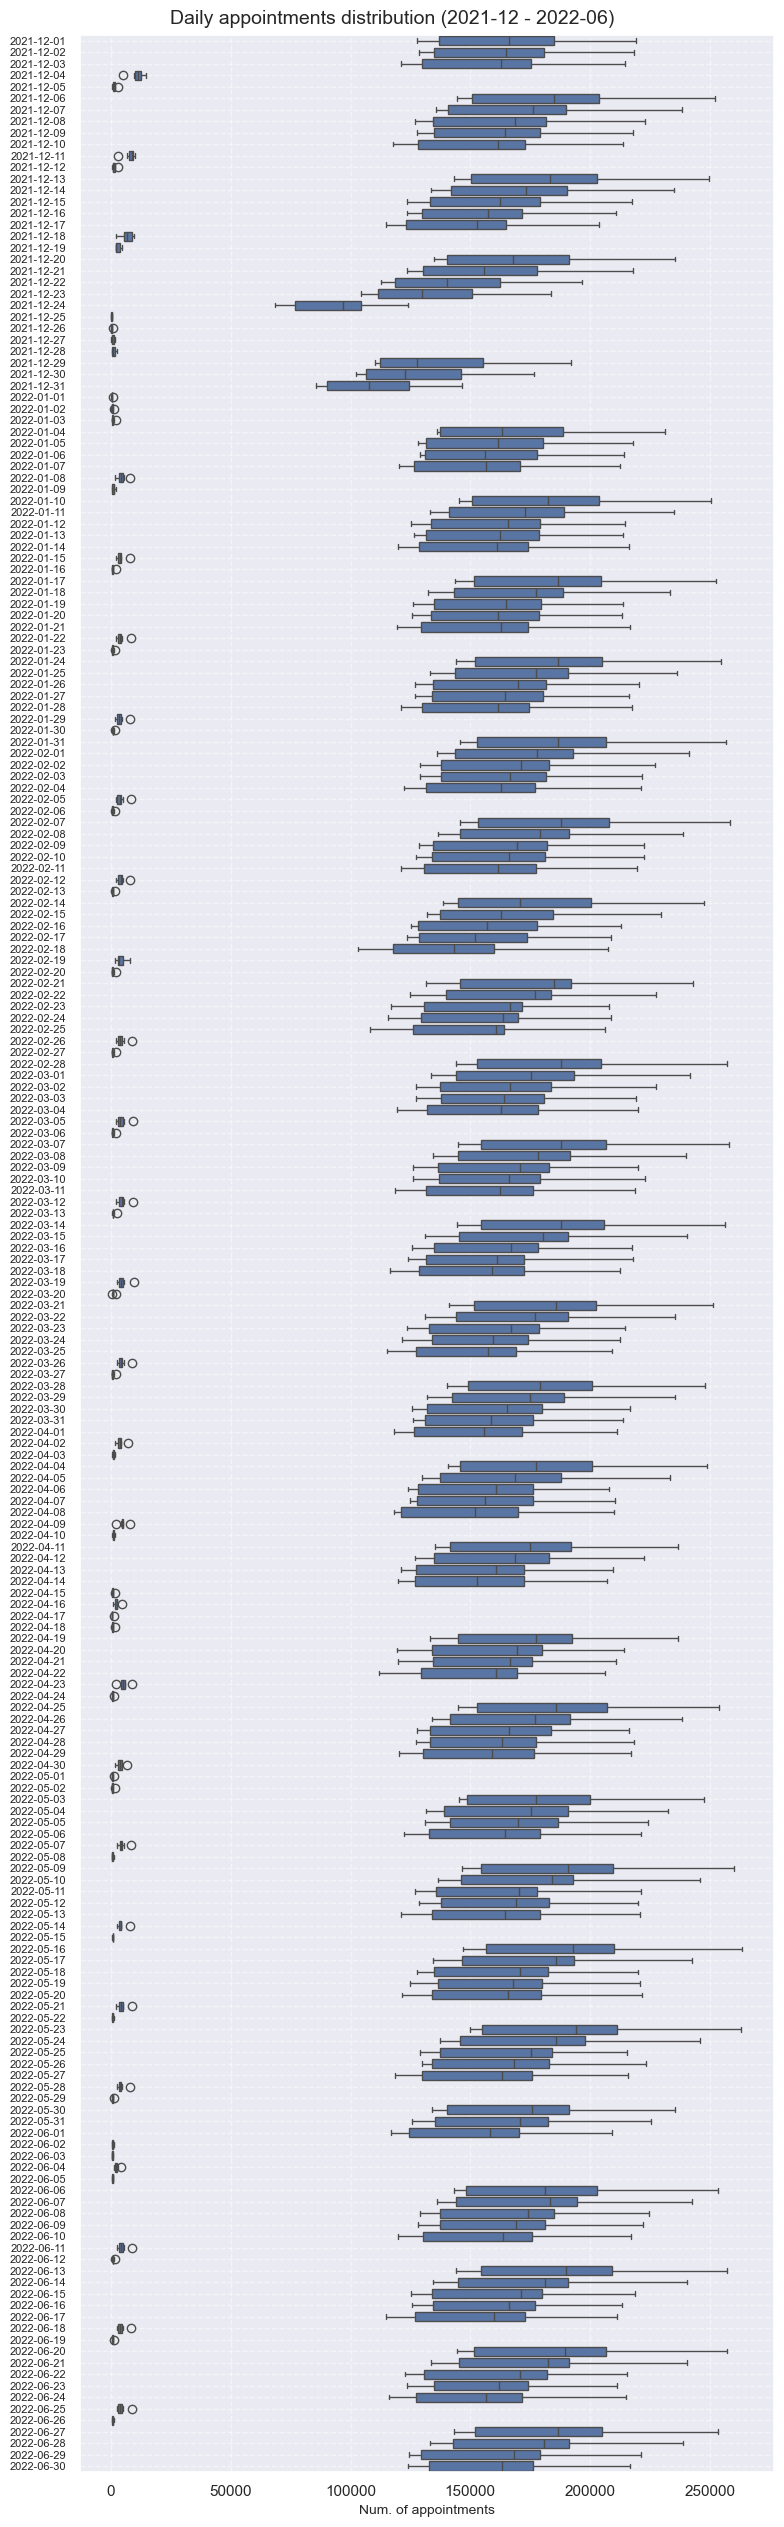

In [1037]:
# Plot daily appointments distribution
ad_fig_daily_distribution_outliers, ax = plt.subplots(1, 1, figsize=(8, 25))
ad_fig_daily_distribution_outliers.suptitle('Daily appointments distribution (2021-12 - 2022-06)', fontsize=14, y=1.01)

sns.boxplot(data=ad_ss_daily_reg,
            y='appointment_date', x='count_of_appointments', 
            ax=ax, linewidth=1)
ax.yaxis.set_label_text(None) # it is obvious from plot title
ax.xaxis.set_label_text("Num. of appointments", fontsize=10)
ax.ticklabel_format(axis='x', style='plain') 
ax.grid(True, linestyle="--", alpha=0.5)
ax.tick_params(axis='y', labelsize=8)

ad_fig_daily_distribution_outliers.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ad_fig_daily_distribution_outliers.show()

(array([18962., 18993., 19024., 19052., 19083., 19113., 19144., 19174.]),
 [Text(18962.0, 0, '2021-12'),
  Text(18993.0, 0, '2022-01'),
  Text(19024.0, 0, '2022-02'),
  Text(19052.0, 0, '2022-03'),
  Text(19083.0, 0, '2022-04'),
  Text(19113.0, 0, '2022-05'),
  Text(19144.0, 0, '2022-06'),
  Text(19174.0, 0, '2022-07')])

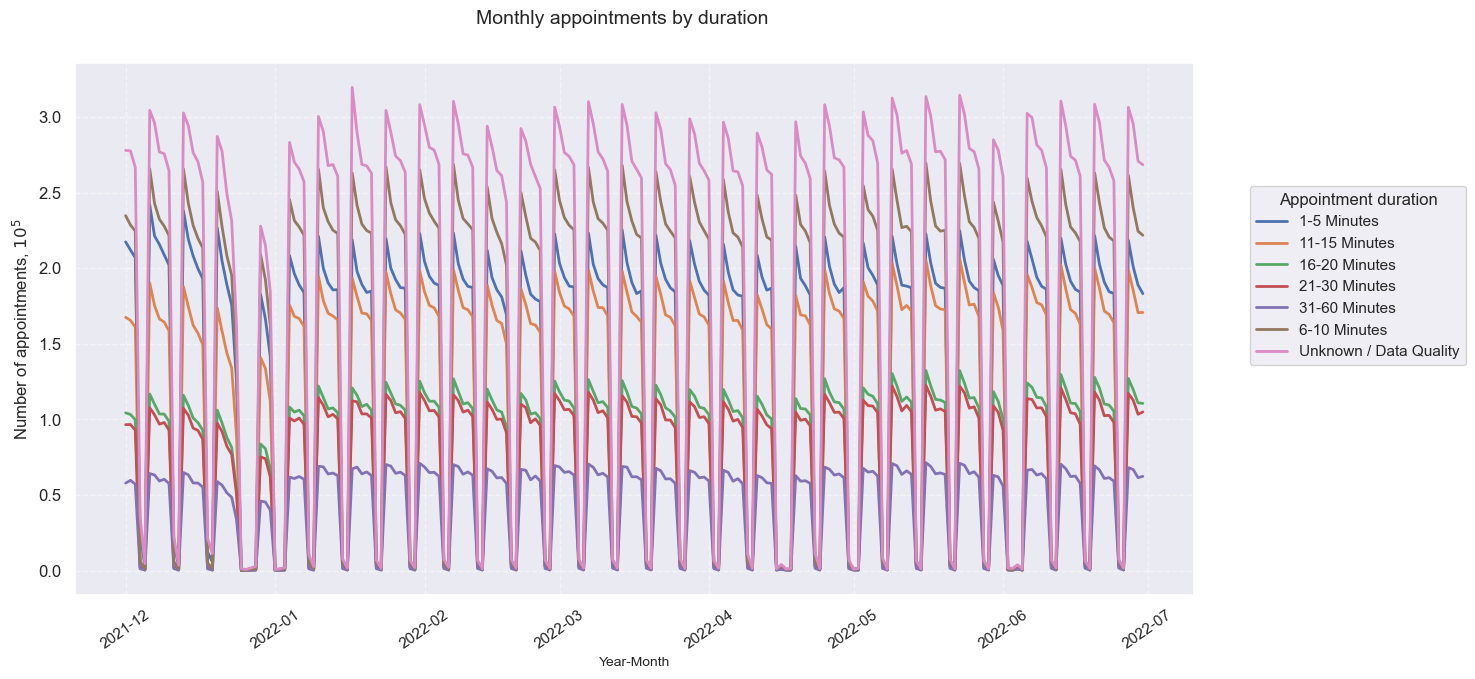

In [1038]:
# Plot the appointments over the available date range, and review for months.

# Plot multiple variables with the same x-axis.
ad_fig_2, ax = plt.subplots(figsize=(12, 6))
ad_fig_2.tight_layout(h_pad=3) # fixes overlapping titles
ad_fig_2.suptitle("Monthly appointments by duration", fontsize=14, y=1.05)

# plot data
sns.lineplot(x='appointment_date', 
            y='count_of_appointments',
            data=ad_ad_monthly,
            hue='actual_duration',
            ci=None,
            linewidth=2)
ax.set_ylabel("Number of appointments, $10^5$")
ax.set_yticklabels(ax.get_yticks()/100000, size=12)
ax.grid(True, linestyle="--", alpha=0.5)

# add axis labels
ax.set_xlabel("Year-Month", fontsize=10)

# Rename legend
plt.legend(title="Appointment duration", bbox_to_anchor = (1.25, 0.6), loc='center right')

plt.xticks(rotation=35)

>Picks up weekly seasonality and Xmas dip. What is the busiest day of the week???

### NC categories over time

#### ------>nc_fig_week_day

In [1042]:
# NC has more days
# Create a day of the week column
nc['week_day'] = nc['appointment_date'].dt.day_name()
nc.head(2)

appointment_date icb_ons_code                       sub_icb_location_name  \
0       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   
1       2021-08-02    E54000050  NHS North East and North Cumbria ICB - 00L   

        service_setting            context_type  \
0  Primary Care Network  Care Related Encounter   
1                 Other  Care Related Encounter   

                        national_category  count_of_appointments  \
0  Patient contact during Care Home Round                      3   
1                         Planned Clinics                      7   

  appointment_month  year  month week_day  
0           2021-08  2021      8   Monday  
1           2021-08  2021      8   Monday

In [1043]:
# Check weekly dynamic 
nc_daily = nc.groupby(['appointment_date','appointment_month', 'week_day'])['count_of_appointments']\
             .sum().reset_index()

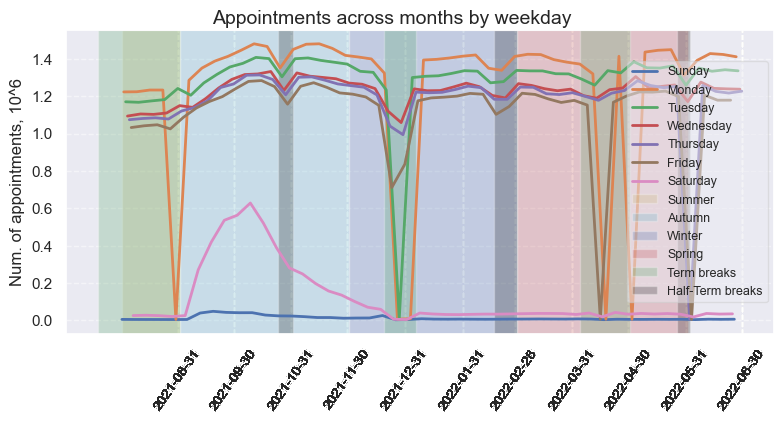

In [1044]:
# Plot weekly trends by day of week
nc_fig_week_day, ax = plt.subplots(1, 1, figsize=(8, 4))
nc_fig_week_day.suptitle('Appointments across months by weekday', fontsize=14, y=1.05)

# for 1x1 canvas
time_series_plot_with_trendline(data=nc_daily,
                                work_axis=ax,
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=True,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=True,
                                time_col='appointment_date', 
                                value_col='count_of_appointments', 
                                subtitle=" ", 
                                ylabel="Num. of appointments, 10^6",
                                hue='week_day')
ax.set_xticks(nc_daily['appointment_month'])

nc_fig_week_day.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.12) # fixes overlapping titles
nc_fig_week_day.show()

In [1045]:
# period[M] data type is suitable for sorting and aggregation
# as established in 'Exploratory analysis continued'
nc['appointment_month'] = nc['appointment_month'].astype("string")

In [1046]:
# Aggregate on monthly level and determine the sum of records per month.
nc_ss = nc.groupby(['appointment_month', 'service_setting']) \
            .agg({'count_of_appointments': 'sum'}).reset_index()            

# View output.
print(nc_ss.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x))

   appointment_month            service_setting count_of_appointments
0            2021-08  Extended Access Provision               160,927
1            2021-08           General Practice            21,575,852
2            2021-08                      Other               449,101
3            2021-08       Primary Care Network               432,448
4            2021-08                   Unmapped             1,233,843
5            2021-09  Extended Access Provision               187,906
6            2021-09           General Practice            25,940,821
7            2021-09                      Other               527,174
8            2021-09       Primary Care Network               530,485
9            2021-09                   Unmapped             1,336,115
10           2021-10  Extended Access Provision               209,539
11           2021-10           General Practice            27,606,171
12           2021-10                      Other               556,487
13           2021-10

In [1047]:
# calculate average appointments per category 
nc_ss_avg = nc_ss.groupby('service_setting') \
            .agg({'count_of_appointments': 'mean'}).reset_index()

nc_ss_avg = nc_ss_avg\
.assign(total_share=lambda x: (x['count_of_appointments'] / x['count_of_appointments'].sum()))

nc_ss_avg.apply(lambda x: round(x, 2) if x.dtype=='float' else x)\
        .sort_values(by='count_of_appointments', ascending=False)

service_setting  count_of_appointments  total_share
1           General Practice          24,619,244.64         0.91
4                   Unmapped           1,007,346.36         0.04
3       Primary Care Network             596,126.00         0.02
2                      Other             492,734.18         0.02
0  Extended Access Provision             197,891.55         0.01

Total calculation [code source](https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/)

In [1049]:
# Split data sets in two for better visual
# (due to substantial categories' spread)
nc_ss_gp = nc_ss[nc_ss['service_setting'].str.contains('General Practice')]
nc_ss_wogp = nc_ss[nc_ss['service_setting'].str.contains('General Practice')==False]

In [1050]:
nc_ss_wogp.sort_values(by='appointment_month', ascending=True)\
            .applymap(format_numbers)

appointment_month            service_setting count_of_appointments
0            2021-08  Extended Access Provision               160,927
2            2021-08                      Other               449,101
3            2021-08       Primary Care Network               432,448
4            2021-08                   Unmapped             1,233,843
5            2021-09  Extended Access Provision               187,906
7            2021-09                      Other               527,174
8            2021-09       Primary Care Network               530,485
9            2021-09                   Unmapped             1,336,115
14           2021-10                   Unmapped             1,366,656
13           2021-10       Primary Care Network               564,981
10           2021-10  Extended Access Provision               209,539
12           2021-10                      Other               556,487
15           2021-11  Extended Access Provision               207,577
17           2021-11                      Other               558,784
18           2021-11       Primary Care Network               614,324
19           2021-11                   Unmapped             1,256,496
20           2021-12  Extended Access Provision               173,504
22           2021-12                      Other               464,718
23           2021-12       Primary Care Network               539,479
24           2021-12                   Unmapped               954,257
29           2022-01                   Unmapped               839,562
28           2022-01       Primary Care Network               569,044
27           2022-01                      Other               457,440
25           2022-01  Extended Access Provision               186,375
30           2022-02  Extended Access Provision               196,627
32           2022-02                      Other               456,153
33           2022-02       Primary Care Network               585,300
34           2022-02                   Unmapped               811,246
35           2022-03  Extended Access Provision               231,905
37           2022-03                      Other               530,677
38           2022-03       Primary Care Network               702,176
39           2022-03                   Unmapped               942,912
44           2022-04                   Unmapped               760,313
43           2022-04       Primary Care Network               606,270
42           2022-04                      Other               437,402
40           2022-04  Extended Access Provision               192,284
45           2022-05  Extended Access Provision               220,511
47           2022-05                      Other               503,327
48           2022-05       Primary Care Network               712,280
49           2022-05                   Unmapped               820,770
50           2022-06  Extended Access Provision               209,652
52           2022-06                      Other               478,813
53           2022-06       Primary Care Network               700,599
54           2022-06                   Unmapped               758,640

**Service settings:**

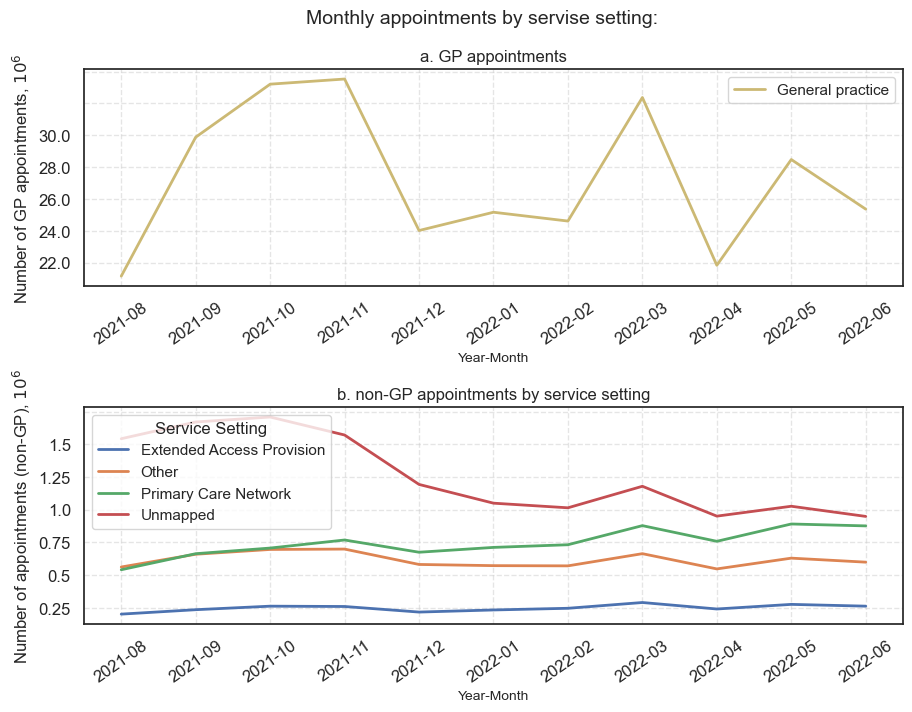

In [1052]:
# Plot the appointments over the available date range, and review the service settings for months.
# Set figure size.
sns.set(rc={'figure.figsize':(9, 6)})

# Set the plot style as white.
sns.set_style('white')
# sns.set_style('ticks')

# Plot multiple variables with the same x-axis.
nc_fig_1, ax = plt.subplots(2, 1)
nc_fig_1.tight_layout(h_pad=5) # fixes overlapping titles

# a. plot GP data
sns.lineplot(x='appointment_month', 
            y='count_of_appointments',
            data=nc_ss_gp,
            ax=ax[0],
            color='y',
            ci=None,
            linewidth=2,
            palette='colorblind')\
            .set_title("a. GP appointments", fontsize=12)
x_labels = nc_ss_gp['appointment_month']
ax[0].set_xticklabels(x_labels, rotation=35, fontsize=12)
ax[0].set_yticklabels(ax[0].get_yticks()/1000000, size=12)
ax[0].set_ylabel("Number of GP appointments, $10^6$")
ax[0].grid(True, linestyle="--", alpha=0.5)
ax[0].legend(['General practice'])

# b. plot non-GP data
sns.lineplot(x='appointment_month', 
            y='count_of_appointments',
            hue="service_setting",
            data=nc_ss_wogp,
            ax=ax[1],
            ci=None,
            linewidth=2)\
            .set_title("b. non-GP appointments by service setting", fontsize=12, y=1)
ax[1].set_xticklabels(x_labels, rotation=35, fontsize=12)
ax[1].set_yticklabels(ax[1].get_yticks()/1000000, size=12)
ax[1].set_ylabel("Number of appointments (non-GP), $10^6$")
ax[1].grid(True, linestyle="--", alpha=0.5)

# add axis labels
ax[0].set_xlabel("Year-Month", fontsize=10)
ax[1].set_xlabel("Year-Month", fontsize=10)

nc_fig_1.suptitle("Monthly appointments by servise setting:", fontsize=14, y=1.1)
plt.subplots_adjust(top=1) # fixes overlapping titles

# Rename legend
plt.legend(title="Service Setting")

Impose one-line legend [code source](https://stackoverflow.com/a/28385399/21407272)

**Context types:**

In [1055]:
# Create a separate data set that can be used in future weeks. 
nc_ct = nc.groupby(['appointment_month', 'context_type']) \
            .agg({'count_of_appointments': 'sum'}).reset_index()            

# View output.
print(nc_ct.applymap(format_numbers))

   appointment_month            context_type count_of_appointments
0            2021-08  Care Related Encounter            20,255,235
1            2021-08    Inconsistent Mapping             2,363,093
2            2021-08                Unmapped             1,233,843
3            2021-09  Care Related Encounter            24,404,251
4            2021-09    Inconsistent Mapping             2,782,135
5            2021-09                Unmapped             1,336,115
6            2021-10  Care Related Encounter            26,125,201
7            2021-10    Inconsistent Mapping             2,811,977
8            2021-10                Unmapped             1,366,656
9            2021-11  Care Related Encounter            26,282,778
10           2021-11    Inconsistent Mapping             2,865,796
11           2021-11                Unmapped             1,256,496
12           2021-12  Care Related Encounter            21,798,612
13           2021-12    Inconsistent Mapping             2,387

In [1056]:
# Calculate average appointments per category 
nc_ct_avg = nc_ct.groupby('context_type') \
            .agg({'count_of_appointments': 'mean'}).reset_index()

nc_ct_avg = nc_ct_avg\
.assign(total_share=lambda x: (x['count_of_appointments'] / x['count_of_appointments'].sum()))

nc_ct_avg.apply(format_numbers)\
        .sort_values(by='count_of_appointments', ascending=False)

context_type  count_of_appointments  total_share
0  Care Related Encounter          23,370,468.91         0.87
1    Inconsistent Mapping           2,535,527.45         0.09
2                Unmapped           1,007,346.36         0.04

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 [Text(0, 0, '2021-08'),
  Text(1, 0, '2021-09'),
  Text(2, 0, '2021-10'),
  Text(3, 0, '2021-11'),
  Text(4, 0, '2021-12'),
  Text(5, 0, '2022-01'),
  Text(6, 0, '2022-02'),
  Text(7, 0, '2022-03'),
  Text(8, 0, '2022-04'),
  Text(9, 0, '2022-05'),
  Text(10, 0, '2022-06')])

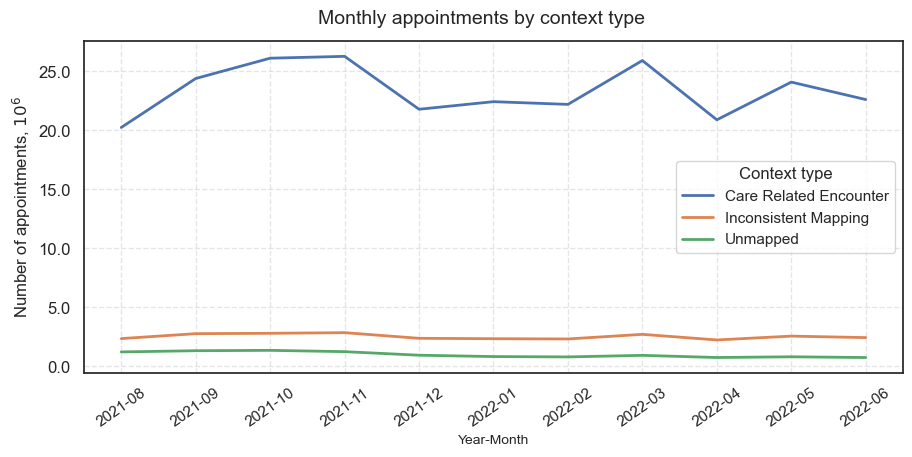

In [1057]:
# Plot the appointments over the available date range, and review the context types for months.

# Set figure size.
sns.set(rc={'figure.figsize':(9, 4)})

# Set the plot style as white.
sns.set_style('white')
# sns.set_style('ticks')

# Plot multiple variables with the same x-axis.
nc_fig_2, ax = plt.subplots()
nc_fig_2.tight_layout() # fixes overlapping titles
nc_fig_2.suptitle("Monthly appointments by context type", fontsize=14, y=1.02)

# plot data
sns.lineplot(x='appointment_month', 
            y='count_of_appointments',
            data=nc_ct,
            hue='context_type',
            ci=None,
            linewidth=2)
ax.set_ylabel("Number of appointments, $10^6$")
ax.set_yticklabels(ax.get_yticks()/1000000, size=12)
ax.grid(True, linestyle="--", alpha=0.5)

# add axis labels
ax.set_xlabel("Year-Month", fontsize=10)

# Rename legend
plt.legend(title="Context type")

plt.xticks(rotation=35)

**National categories:**

In [1059]:
# Calculate average appointments per category 
nc_nc_avg = nc.groupby('national_category') \
            .agg({'count_of_appointments': 'mean'}).reset_index()

nc_nc_avg = nc_nc_avg\
.assign(total_share=lambda x: (x['count_of_appointments'] / x['count_of_appointments'].sum()))

nc_nc_avg.apply(lambda x: round(x, 2) if x.dtype=='float' else x)\
        .sort_values(by='count_of_appointments', ascending=False)

national_category  \
4                                          General Consultation Routine   
3                                            General Consultation Acute   
2                                                       Clinical Triage   
10                                           Planned Clinical Procedure   
15                                                             Unmapped   
11                                                      Planned Clinics   
7                                                  Inconsistent Mapping   
16                                          Unplanned Clinical Activity   
6                                                            Home Visit   
14                                         Structured Medication Review   
17                                                              Walk-in   
9                                Patient contact during Care Home Round   
1                                                       Care Home Visit   
12            Service provided by organisation external to the practice   
13                                           Social Prescribing Service   
0   Care Home Needs Assessment & Personalised Care and Support Planning   
5                                Group Consultation and Group Education   
8                                       Non-contractual chargeable work   

    count_of_appointments  total_share  
4                1,088.91         0.26  
3                  632.60         0.15  
2                  557.39         0.14  
10                 431.03         0.10  
15                 404.13         0.10  
11                 366.61         0.09  
7                  311.65         0.08  
16                  75.61         0.02  
6                   51.24         0.01  
14                  41.79         0.01  
17                  29.09         0.01  
9                   28.14         0.01  
1                   23.58         0.01  
12                  19.77         0.00  
13                  17.96         0.00  
0                   17.27         0.00  
5                   11.35         0.00  
8                    6.65         0.00

In [1060]:
# Create a separate data set that can be used in future weeks. 
nc_monthly = nc.groupby(['appointment_month',
                         'service_setting',
                         'context_type',
                         'national_category']) \
                .agg({'count_of_appointments': 'sum'}).reset_index()    

# Filter for 'General Consultation Routine'
nc_monthly_gcroutine = nc_monthly[nc_monthly['national_category']\
                        .str.contains('General Consultation Routine')==True]\
                        .reset_index()

# Filter out 'General Consultation Routine'
nc_monthly_nogcroutine = nc_monthly[nc_monthly['national_category']\
                        .str.contains('General Consultation Routine')==False]\
                        .reset_index()
# View output.
# nc_monthly.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

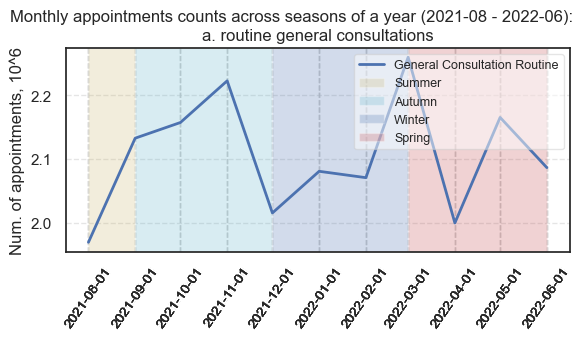

In [1061]:
# Plot Monthly appointments counts
nc_fig_gcroutine, ax = plt.subplots(1, 1, figsize=(6, 3))
nc_fig_gcroutine.suptitle('Monthly appointments counts across seasons of a year (2021-08 - 2022-06):', fontsize=12, y=1.13)

# a. by health care professional (hcp)
time_series_plot_with_trendline(data=nc_monthly_gcroutine,
                                work_axis=ax,
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=True,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. routine general consultations", 
                                ylabel="Num. of appointments, 10^6",
                                hue='national_category')

nc_fig_gcroutine.tight_layout(h_pad=2) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
nc_fig_gcroutine.show()

# Save figures to PNG
# nc_fig_gcroutine.savefig('nc_fig_gcroutine.png', bbox_inches='tight')
# plt.close(nc_fig_gcroutine)

In [1062]:
# Subset data for only four most frequent categories
nc_ss_ncs = nc_monthly[nc_monthly['national_category'].isin(['Clinical Triage',
                                                             'General Consultation Acute',
                                                             'General Consultation Routine',
                                                             'Planned Clinical Procedure',
                                                             'Unmapped'])]

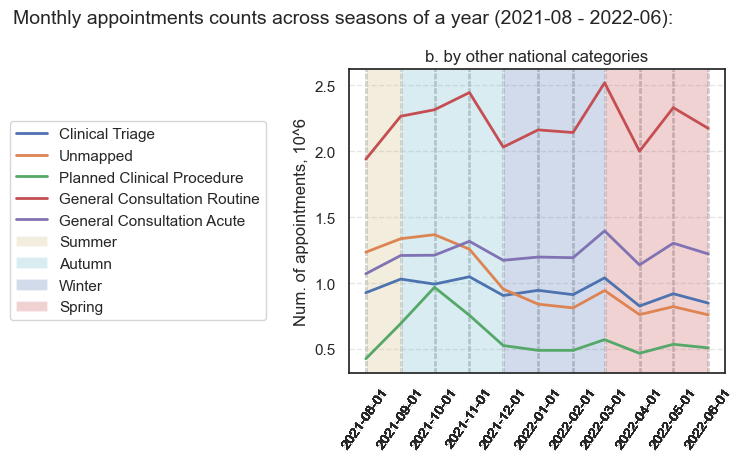

In [1063]:
# Plot Monthly appointments counts
nc_fig_nogcroutine, ax = plt.subplots(1, 1, figsize=(8, 4))
nc_fig_nogcroutine.suptitle('Monthly appointments counts across seasons of a year (2021-08 - 2022-06):', fontsize=14, y=1.15)

# b. by national category
time_series_plot_with_trendline(data=nc_ss_ncs,
                                work_axis=ax,
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=True,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. by other national categories", 
                                ylabel="Num. of appointments, 10^6",
                                hue='national_category')
ax.legend(bbox_to_anchor=(-0.2,0.5), loc='center right')
sns.color_palette()
nc_fig_nogcroutine.tight_layout(h_pad=2) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
nc_fig_nogcroutine.show()

# Save figures to PNG
# nc_fig_nogcroutine.savefig('nc_fig_nogcroutine.png', bbox_inches='tight')
# plt.close(nc_fig_nogcroutine)

Legend location code [source](https://www.geeksforgeeks.org/how-to-place-legend-outside-of-the-plot-in-matplotlib/)

### AR categories over time

**Question 1:** Should the NHS start looking at increasing staff levels? 

#### ----->ar_fig_total_capacity

In [1068]:
# Determine the total number of appointments per month.
ar_monthly_dif = ar.groupby(['appointment_month']) \
                 .agg({'count_of_appointments': 'sum'})\
                 .reset_index()

# Add a new column to indicate the average utilisation of services.
# Monthly avg. 30 000 000 from oue
ar_monthly_dif = ar_monthly_dif\
.assign(difference_with_average=lambda x: (x['count_of_appointments'] - 30000000))

# View the DataFrame.
ar_monthly_dif.applymap(lambda x: "{:,.1f}".format(x) if isinstance(x, (int, float)) else x)

appointment_month count_of_appointments difference_with_average
0            2020-01          27,199,296.0            -2,800,704.0
1            2020-02          24,104,621.0            -5,895,379.0
2            2020-03          24,053,468.0            -5,946,532.0
3            2020-04          16,007,881.0           -13,992,119.0
4            2020-05          16,417,212.0           -13,582,788.0
5            2020-06          20,690,805.0            -9,309,195.0
6            2020-07          22,491,437.0            -7,508,563.0
7            2020-08          20,150,520.0            -9,849,480.0
8            2020-09          26,714,255.0            -3,285,745.0
9            2020-10          28,301,932.0            -1,698,068.0
10           2020-11          25,061,602.0            -4,938,398.0
11           2020-12          23,535,936.0            -6,464,064.0
12           2021-01          22,492,069.0            -7,507,931.0
13           2021-02          22,399,569.0            -7,600,431.0
14           2021-03          27,225,424.0            -2,774,576.0
15           2021-04          23,879,932.0            -6,120,068.0
16           2021-05          23,508,395.0            -6,491,605.0
17           2021-06          26,784,182.0            -3,215,818.0
18           2021-07          25,739,219.0            -4,260,781.0
19           2021-08          23,852,171.0            -6,147,829.0
20           2021-09          28,522,501.0            -1,477,499.0
21           2021-10          30,303,834.0               303,834.0
22           2021-11          30,405,070.0               405,070.0
23           2021-12          25,140,776.0            -4,859,224.0
24           2022-01          25,635,474.0            -4,364,526.0
25           2022-02          25,355,260.0            -4,644,740.0
26           2022-03          29,595,038.0              -404,962.0
27           2022-04          23,913,060.0            -6,086,940.0
28           2022-05          27,495,508.0            -2,504,492.0
29           2022-06          25,828,078.0            -4,171,922.0

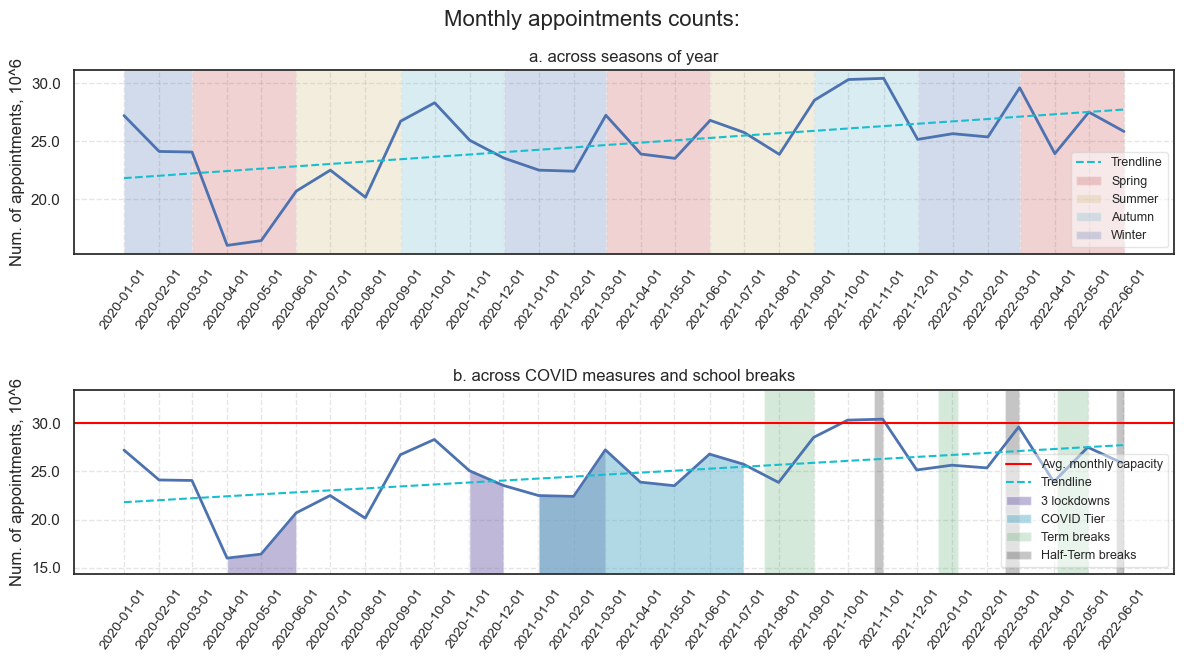

In [1069]:
# Plot Monthly appointments counts
ar_fig_total_capacity, ax = plt.subplots(2, 1, figsize=(12, 6))
ar_fig_total_capacity.suptitle('Monthly appointments counts:', fontsize=16, y=1.1)

ar_monthly_dif['appointment_month'] = ar_monthly_dif['appointment_month'].astype(str)

# a. across seasons of year
time_series_plot_with_trendline(data=ar_monthly_dif,
                                work_axis=ax[0],
                                avgcapacity=False,
                                trendline=True,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. across seasons of year", 
                                ylabel="Num. of appointments, 10^6")
# b. across relevant events and school breaks
time_series_plot_with_trendline(data=ar_monthly_dif,
                                work_axis=ax[1],
                                avgcapacity=True,
                                trendline=True,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=False,
                                lockdowns=True,
                                lockdowns_alt=False,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. across COVID measures and school breaks", 
                                ylabel="Num. of appointments, 10^6")
ar_fig_total_capacity.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ar_fig_total_capacity.show()

>Increase in appointments counts are identified during second half of every season of a year, except Autum'2020 when 2nd COVID lockdown took place.
>The highest seasonal number of appointments takes place during school breaks/half-terms.
>In Autumn 2021 GP is over the monthly capacity benchmark of 30,000,000 appointments.

In [1071]:
# Doublecheck dates data type
ar['appointment_month'] = ar['appointment_month'].astype("string") 

# Group by month and status
ar_monthly_sta = ar.groupby(['appointment_status', 'appointment_month'])\
                            ['count_of_appointments'].sum().reset_index()

# Group by month and hcp
ar_monthly_hcp = ar.groupby(['hcp_type', 'appointment_month'])\
                            ['count_of_appointments'].sum().reset_index()

# Group by month and mode
ar_monthly_mod = ar.groupby(['appointment_mode', 'appointment_month'])\
                            ['count_of_appointments'].sum().reset_index()

# Group by month and 'between'
ar_monthly_bn = ar.groupby(['time_between_book_and_appointment', 'appointment_month'])\
                            ['count_of_appointments'].sum().reset_index()

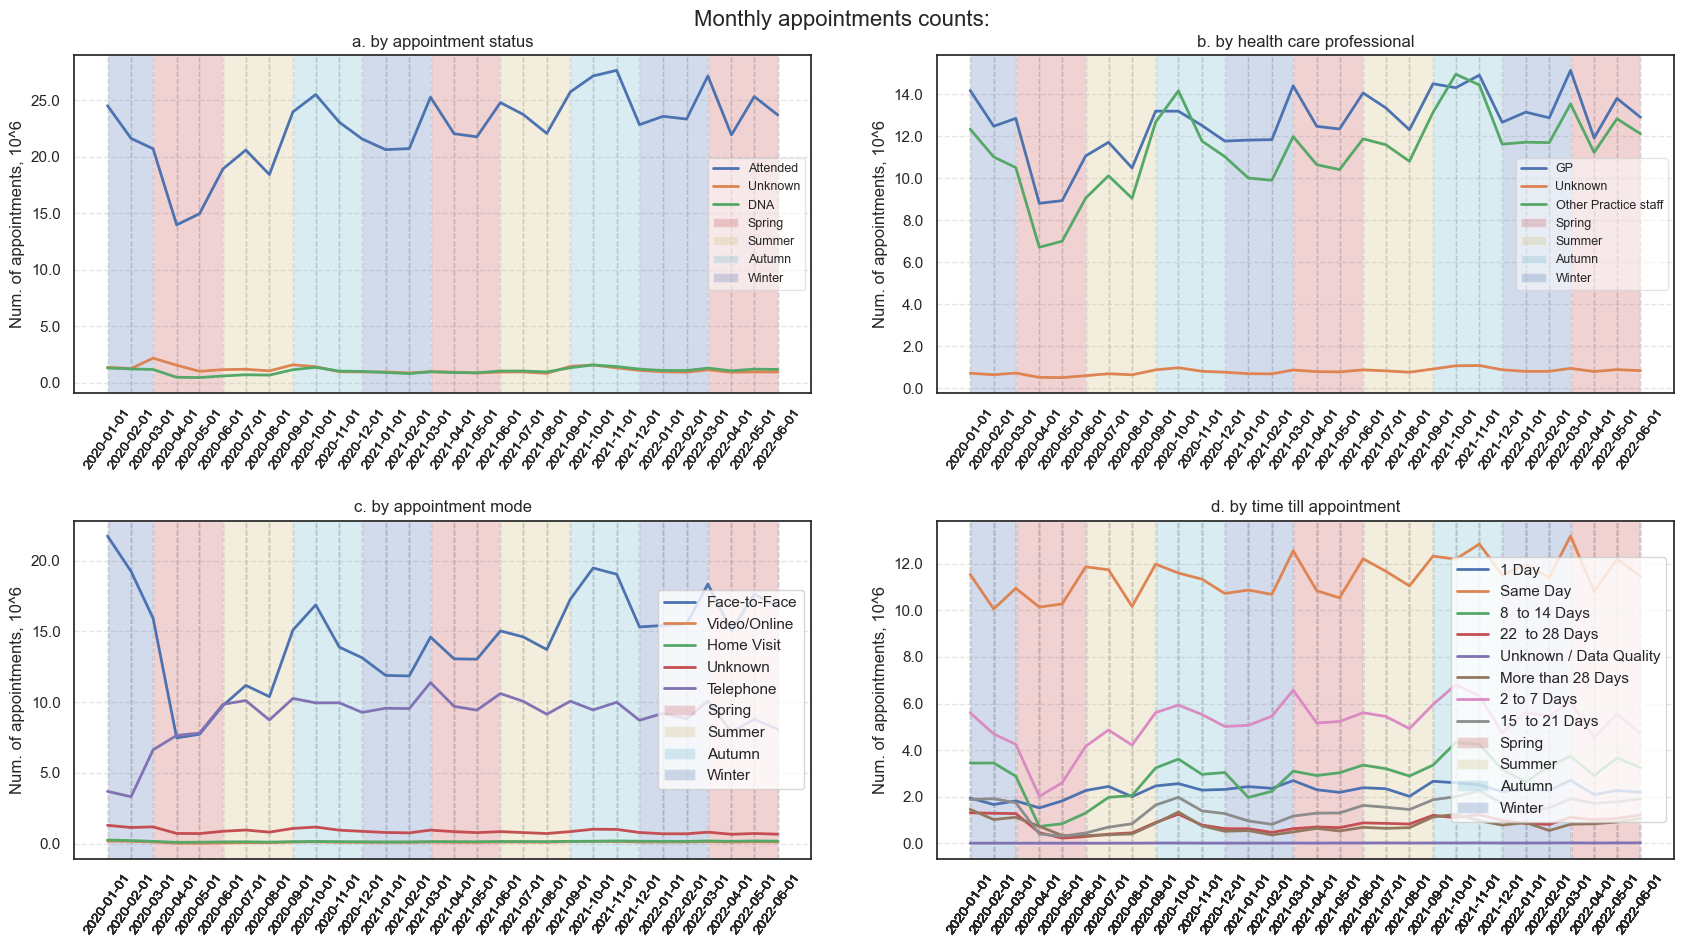

In [1072]:
# Plot Monthly appointments counts
ar_fig_categories, ax = plt.subplots(2, 2, figsize=(17, 9))
ar_fig_categories.suptitle('Monthly appointments counts:', fontsize=16, y=1.05)

# a. by appointment status
time_series_plot_with_trendline(data=ar_monthly_sta,
                                work_axis=ax[0,0],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. by appointment status", 
                                ylabel="Num. of appointments, 10^6",
                                hue='appointment_status')
# b. daily average across relevant events and school breaks
time_series_plot_with_trendline(data=ar_monthly_hcp,
                                work_axis=ax[0,1],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. by health care professional", 
                                ylabel="Num. of appointments, 10^6",
                                hue='hcp_type')
# c. by appointment mode
time_series_plot_with_trendline(data=ar_monthly_mod,
                                work_axis=ax[1,0],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="c. by appointment mode", 
                                ylabel="Num. of appointments, 10^6",
                                hue='appointment_mode')
ax[1,0].legend(loc='center right')

# d. by time till appointment
time_series_plot_with_trendline(data=ar_monthly_bn,
                                work_axis=ax[1,1],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="d. by time till appointment", 
                                ylabel="Num. of appointments, 10^6",
                                hue='time_between_book_and_appointment')
ax[1,1].legend(loc='center right')

ar_fig_categories.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.17) # fixes overlapping titles
ar_fig_categories.show()

# Save figures to PNG
# ar_fig_categories.savefig('ar_fig_categories.png', bbox_inches='tight')
# plt.close(ar_fig_categories)

In [1073]:
# Prepare two datasets:
ar_monthly_categories = ar.groupby(['appointment_month', 'appointment_status',
                                   'hcp_type','appointment_mode',
                                   'time_between_book_and_appointment'])\
                                    ['count_of_appointments'].sum().reset_index()

# Attended dataset
ar_monthly_attended = ar_monthly_categories[ar_monthly_categories['appointment_status']\
                                            .str.contains('Attended')==True]\
                                            .reset_index()
# Not attended dataset 
ar_monthly_dna = ar_monthly_categories[ar_monthly_categories['appointment_status']\
                                            .str.contains('DNA')==True]\
                                            .reset_index()

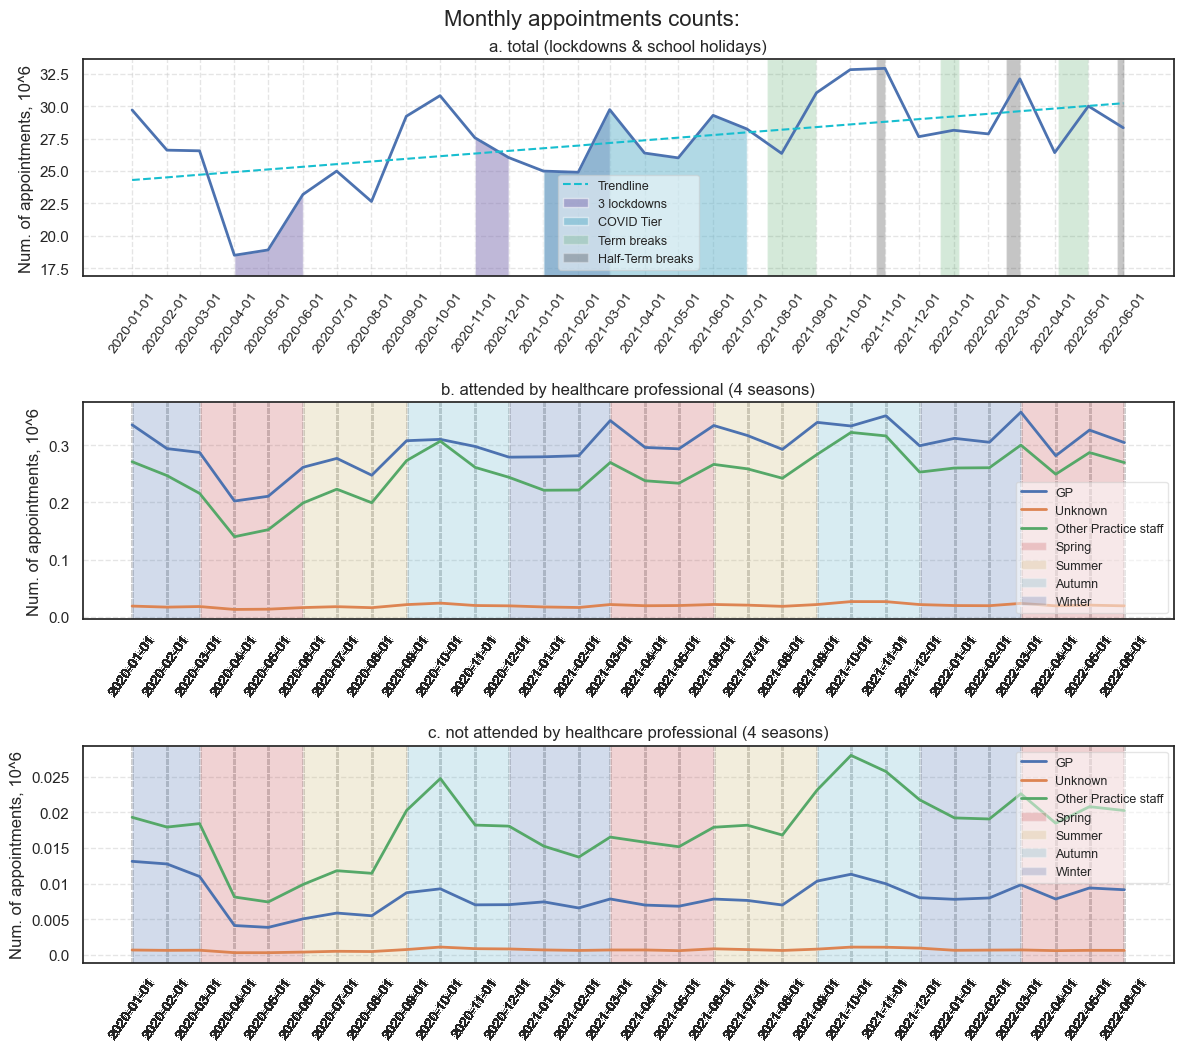

In [1074]:
#Plot total, attended and not attended appointments by categories
ar_fig_att_vs_dna, ax = plt.subplots(3, 1, figsize=(12, 10))
ar_fig_att_vs_dna.suptitle('Monthly appointments counts:', fontsize=16, y=1.05)

# a. total (lockdowns & school holidays)
time_series_plot_with_trendline(data=ar_monthly_dif,
                                work_axis=ax[0],
                                avgcapacity=False,
                                trendline=True,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=False,
                                lockdowns=True,
                                lockdowns_alt=False,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. total (lockdowns & school holidays)", 
                                ylabel="Num. of appointments, 10^6")

# b. attended by category (4 seasons)
time_series_plot_with_trendline(data=ar_monthly_attended,
                                work_axis=ax[1],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. attended by healthcare professional (4 seasons)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='hcp_type')
# c. dna by category (4 seasons)
time_series_plot_with_trendline(data=ar_monthly_dna,
                                work_axis=ax[2],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="c. not attended by healthcare professional (4 seasons)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='hcp_type')
ar_fig_att_vs_dna.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ar_fig_att_vs_dna.show()

# Save figures to PNG
# ar_fig_att_vs_dna.savefig('ar_fig_att_vs_dna.png', bbox_inches='tight')
# plt.close(ar_fig_att_vs_dna)

>During pandemic GP appointments were the most attended whereas 'Other Practice staff' were most unattended.
>In Autumn period both before and postpandemic 'Other Practice staff' appointments tend to the level of GP appointments.
>End of November 2021 - the 1st half-term - is the busiest month for the both types of health care professionals.

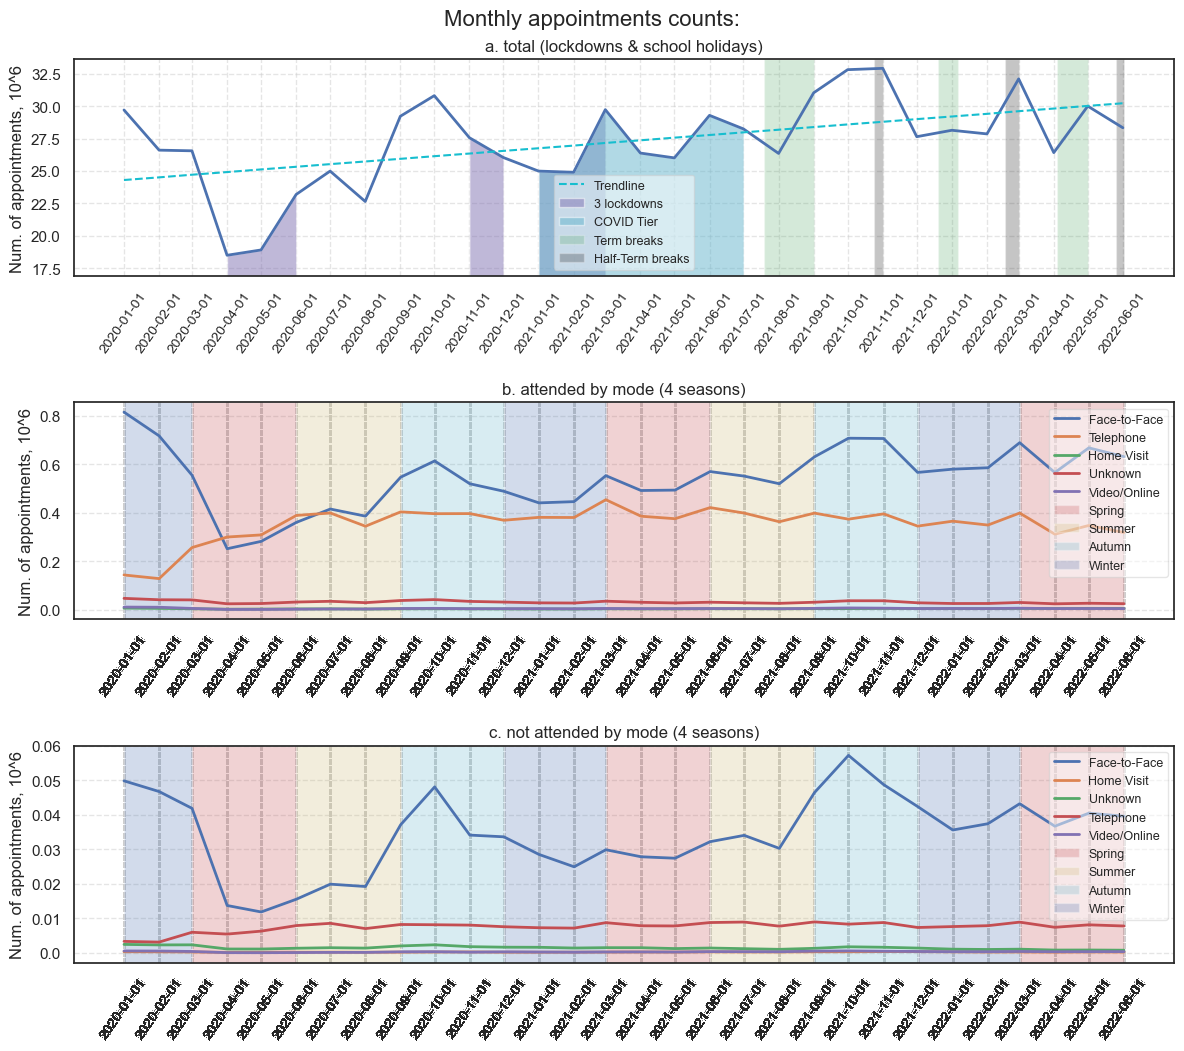

In [1076]:
#Plot total, attended and not attended appointments by categories
ar_fig_att_vs_dna_mode, ax = plt.subplots(3, 1, figsize=(12, 10))
ar_fig_att_vs_dna_mode.suptitle('Monthly appointments counts:', fontsize=16, y=1.05)

# a. total (lockdowns & school holidays)
time_series_plot_with_trendline(data=ar_monthly_dif,
                                work_axis=ax[0],
                                avgcapacity=False,
                                trendline=True,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=False,
                                lockdowns=True,
                                lockdowns_alt=False,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. total (lockdowns & school holidays)", 
                                ylabel="Num. of appointments, 10^6")

# b. attended by appointment mode (4 seasons)
time_series_plot_with_trendline(data=ar_monthly_attended,
                                work_axis=ax[1],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. attended by mode (4 seasons)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='appointment_mode')

# c. dna by appointment mode  (4 seasons)
time_series_plot_with_trendline(data=ar_monthly_dna,
                                work_axis=ax[2],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="c. not attended by mode (4 seasons)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='appointment_mode')
ar_fig_att_vs_dna_mode.tight_layout(h_pad=1) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ar_fig_att_vs_dna_mode.show()

>During 1st lockdown Telephone appointments replaced some face-to-face appointments. Face-to-face reach the highest numbers in Autumn season. During the busiest time in the end of November 2021 - the 1st half-term - pre-Xmas - face-to-face are most attended as well as most missed. Reduce missed!!!

**Question 2:** How do the healthcare professional types differ over time?

#### ----->ar_nc_fig_hcp

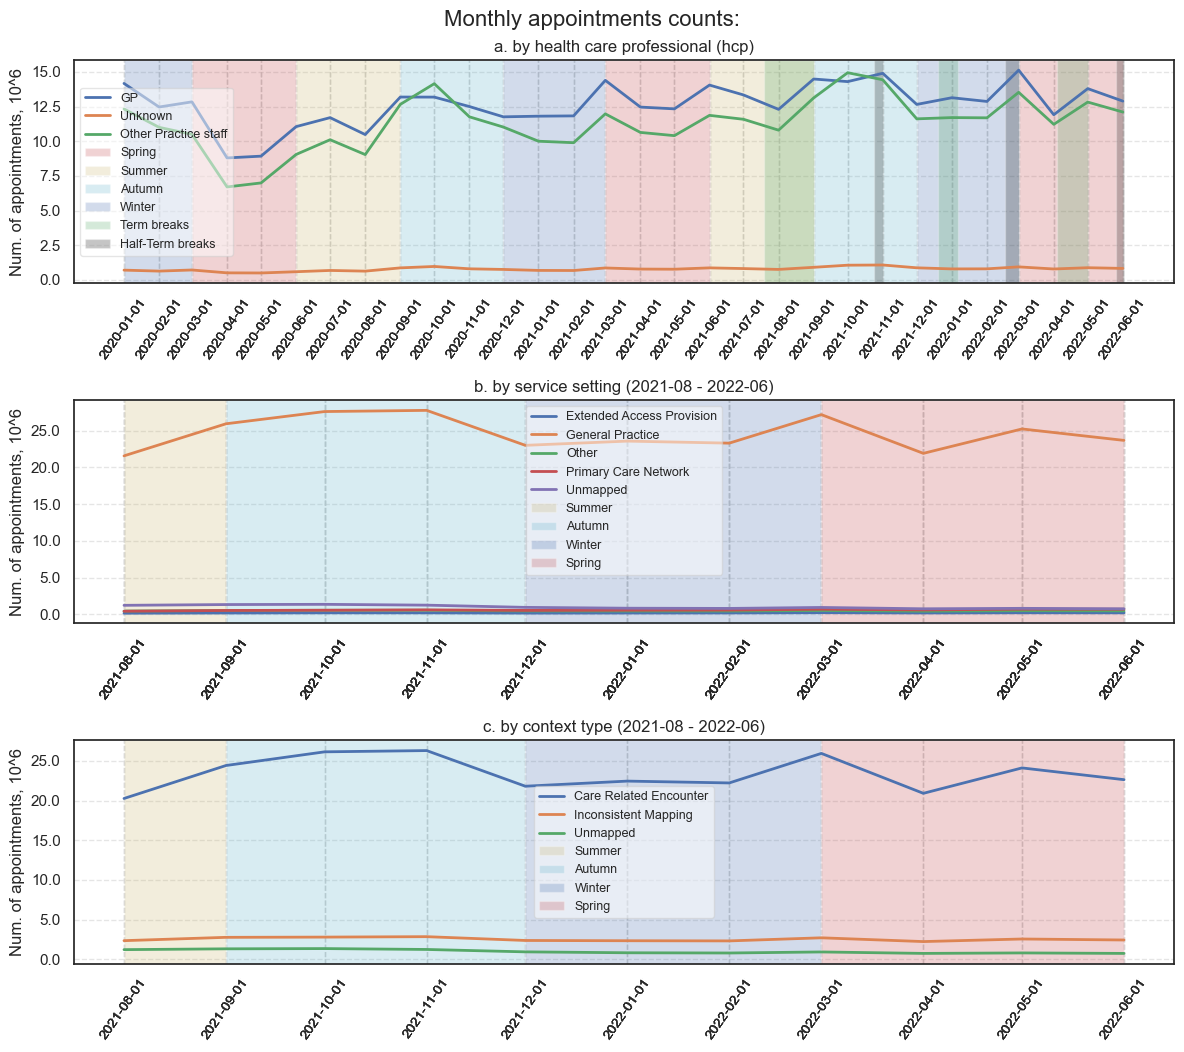

In [1080]:
# Plot Monthly appointments counts
ar_nc_fig_hcp, ax = plt.subplots(3, 1, figsize=(12, 10))
ar_nc_fig_hcp.suptitle('Monthly appointments counts:', fontsize=16, y=1.05)

# a. by health care professional (hcp)
time_series_plot_with_trendline(data=ar_monthly_hcp,
                                work_axis=ax[0],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. by health care professional (hcp)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='hcp_type')
# b. by service setting
time_series_plot_with_trendline(data=nc_ss,
                                work_axis=ax[1],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=True,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. by service setting (2021-08 - 2022-06)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='service_setting')
# c. by context type
time_series_plot_with_trendline(data=nc_ct,
                                work_axis=ax[2],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=True,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="c. by context type (2021-08 - 2022-06)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='context_type')

ar_nc_fig_hcp.tight_layout(h_pad=0.5) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ar_nc_fig_hcp.show()

#### ----->ar_fig_att_vs_dna_bn

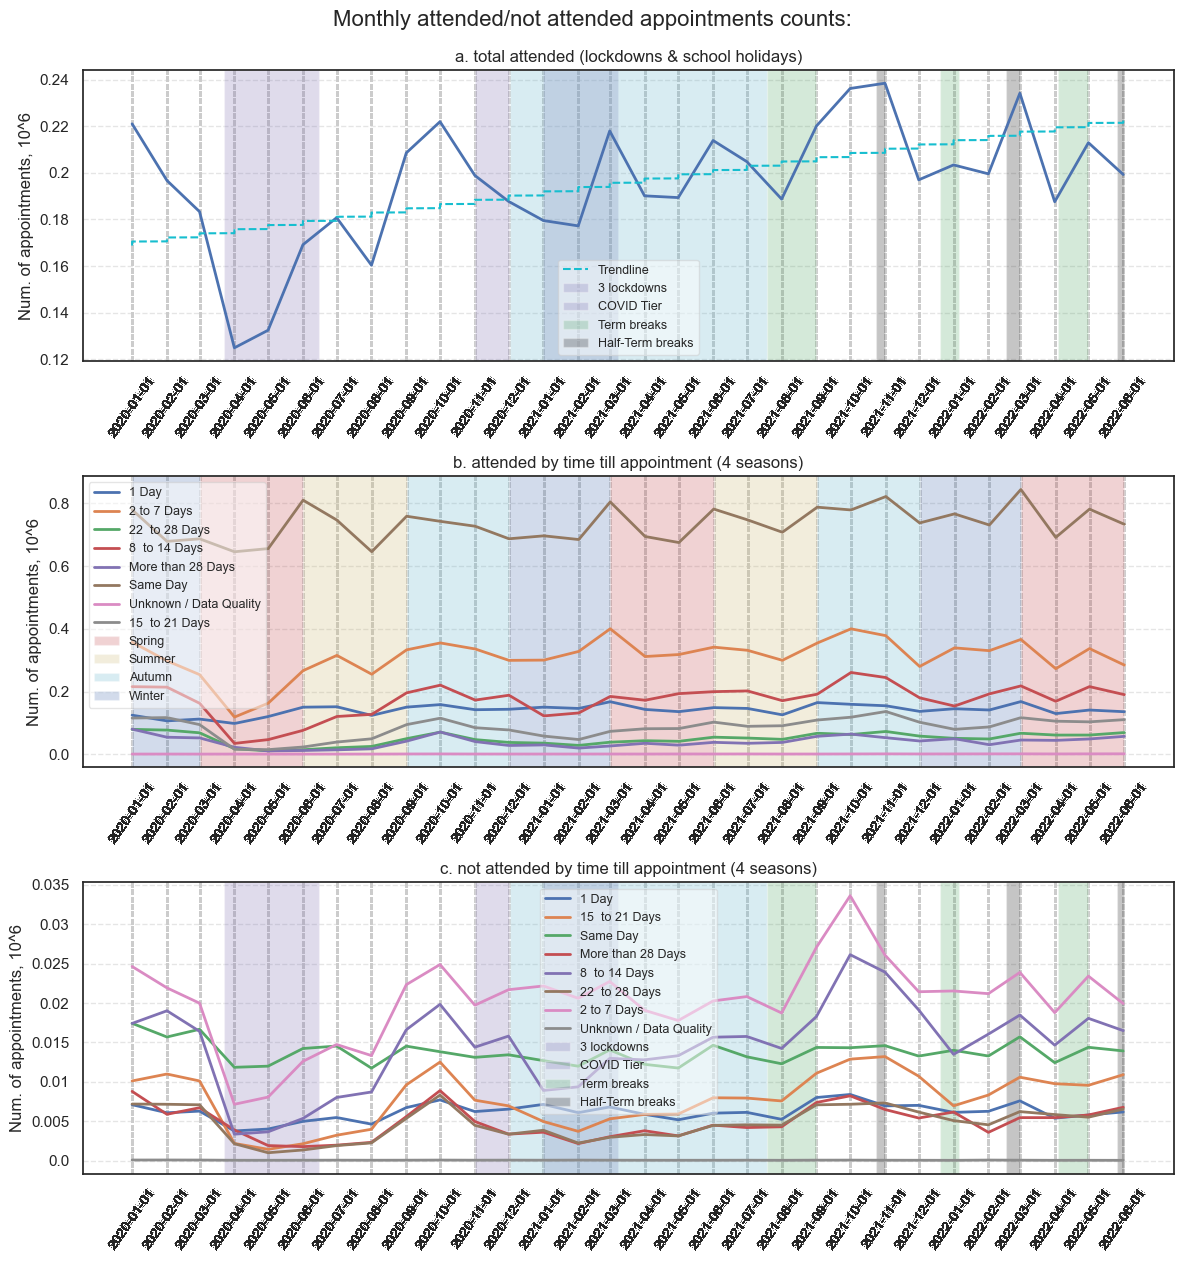

In [1082]:
#Plot total, attended and not attended appointments by categories
ar_fig_att_vs_dna_bn, ax = plt.subplots(3, 1, figsize=(12, 12))
ar_fig_att_vs_dna_bn.suptitle('Monthly attended/not attended appointments counts:', fontsize=16, y=1.05)

# a. total (lockdowns & school holidays)
time_series_plot_with_trendline(data=ar_monthly_attended,
                                work_axis=ax[0],
                                avgcapacity=False,
                                trendline=True,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=True,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. total attended (lockdowns & school holidays)", 
                                ylabel="Num. of appointments, 10^6")

# b. attended by category (4 seasons)
time_series_plot_with_trendline(data=ar_monthly_attended,
                                work_axis=ax[1],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=True,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. attended by time till appointment (4 seasons)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='time_between_book_and_appointment')
# c. dna by category (4 seasons)
time_series_plot_with_trendline(data=ar_monthly_dna,
                                work_axis=ax[2],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=True,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="c. not attended by time till appointment (4 seasons)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='time_between_book_and_appointment')
ar_fig_att_vs_dna_bn.tight_layout(h_pad=0.5) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ar_fig_att_vs_dna_bn.show()

#### ----->ar_nc_fig_att_sameday_mode_nc

In [1084]:
# Subset sameday attended appointments to see their mode
ar_monthly_attended_sameday = ar_monthly_attended[ar_monthly_attended['time_between_book_and_appointment']\
                                                                .isin(['Same Day'])]

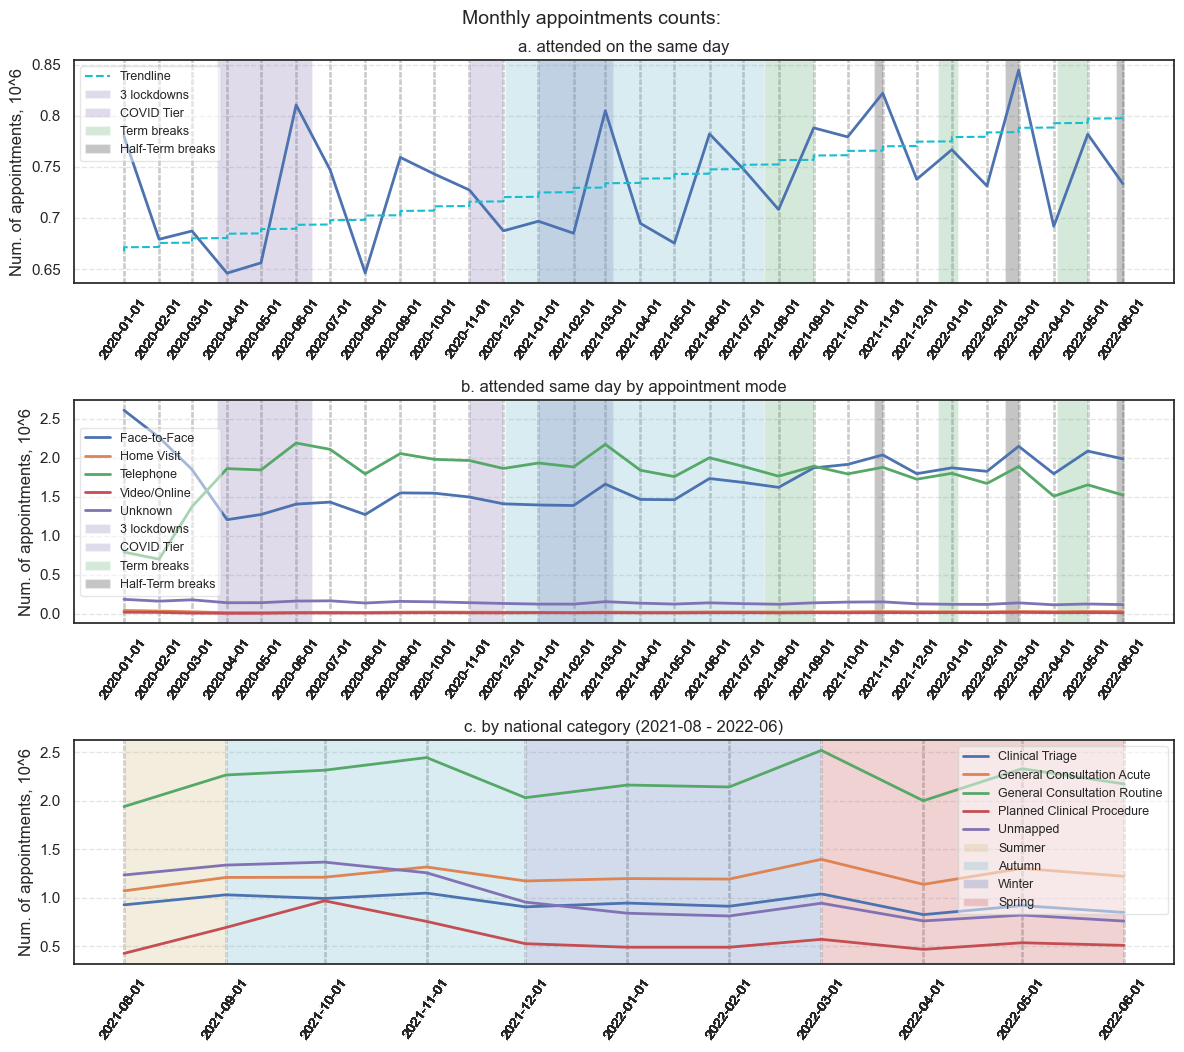

In [1085]:
# Plot Monthly appointments counts
ar_nc_fig_att_sameday_mode_nc, ax = plt.subplots(3, 1, figsize=(12, 10))
ar_nc_fig_att_sameday_mode_nc.suptitle('Monthly appointments counts:', fontsize=14, y=1.05)

# a. 
time_series_plot_with_trendline(data=ar_monthly_attended_sameday,
                                work_axis=ax[0],
                                avgcapacity=False,
                                trendline=True,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=True,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="a. attended on the same day", 
                                ylabel="Num. of appointments, 10^6")
# b. 
time_series_plot_with_trendline(data=ar_monthly_attended_sameday,
                                work_axis=ax[1],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=False,
                                lockdowns=False,
                                lockdowns_alt=True,
                                schoolbreaks=True,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="b. attended same day by appointment mode", 
                                ylabel="Num. of appointments, 10^6",
                                hue='appointment_mode')
# c. 
time_series_plot_with_trendline(data=nc_ss_ncs,
                                work_axis=ax[2],
                                avgcapacity=False,
                                trendline=False,
                                seasons_ad=False,
                                seasons_ar=False,
                                seasons_nc=True,
                                lockdowns=False,
                                lockdowns_alt=False,
                                schoolbreaks=False,
                                time_col='appointment_month', 
                                value_col='count_of_appointments', 
                                subtitle="c. by national category (2021-08 - 2022-06)", 
                                ylabel="Num. of appointments, 10^6",
                                hue='national_category')

ar_nc_fig_att_sameday_mode_nc.tight_layout(h_pad=0.5) # fixes overlapping titles
plt.subplots_adjust(top=1, wspace=0.14) # fixes overlapping titles
ar_nc_fig_att_sameday_mode_nc.show()

# - Analyst's observations:

- **AD** ar_fig_distribution_outliers:
- Outliers are not excluded as they are a small number of GP and extended access weekend appointments [(NHS England)](https://www.england.nhs.uk/gp/investment/gp-contract/network-contract-directed-enhanced-service-des/enhanced-access-faqs/#:~:text=Sundays%20are%20not%20a%20mandatory,adjusted%20population%20required%20each%20week.)
- **NC & AR** ar_fig_hcp, nc_fig_nogcroutine, nc_fig_gcroutine, ar_nc_fig_att_sameday_mode_nc:
- Spike in appointments with AR - 'other practice staff' in first half of Autum'2021 is seen predominantly in GP service setting among such national categories as 'general consultation routine', 'clinical triage', 'general consultation acute'.
- It corresponds to 'unmapped context type' emphasizing the importance of data input quality improvement.
- During 1st lockdown Telephone appointments replaced some fact-to-face appointments. Face-to-face reach the highest numbers in Autumn season.
- - Need to know national category for the COVID period to check whether categories corresponding to those that could offer to be seen the same day [(NHS England)](https://www.england.nhs.uk/long-read/recording-gp-appointments-consolidated-guidance/) could be conducted over the phone instead of face-to-face for resource use optimisation and increased attendance
- **AR** ar_fig_total_avg_capacity, ar_fig_att_vs_dna, ar_fig_att_vs_dna_mode, ar_fig_att_vs_dna_bn:
- Increase in appointments counts are identified during second half of every season of a year, except Autum'2020 when 2nd COVID lockdown took place.
- The highest seasonal number of appointments takes place during school breaks/half-terms.
- - "According to NHS Digital data, in 2022, the average number of GP appointments per month in England was around 30 million, based on figures like the 30.1 million appointments recorded in March 2022" [(NHS Digital)](https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/march-2022). The monthly benchmark has been reached through the busiest period.
- During pandemic GP appointments were the most attended whereas 'Other Practice staff' were most unattended.
- In Autumn period both before and postpandemic 'Other Practice staff' appointments tend to the level of GP appointments.
- End of November 2021 - the 1st half-term - is the busiest month for the both types of health care professionals..
- During the busiest time in the end of November 2021 - the 1st half-term - pre-Xmas - face-to-face are most attended as well as most missed. Reduced missed!!!
- During 1st lockdown same day appointments were more often missed than those scheduled 2-7 and 8-14 ahead. Opposite in Oct-Nov 2021. Same day highest during the busiest period

# Seasons of year

Create four visualisations indicating the number of appointments for service setting per season. The seasons are summer (June to August 2021), autumn (September to November 2021), winter (December to February 2022), and spring (March to May 2022).

**Summer (June to August 2021):**

In [1091]:
# nc.info()

In [1092]:
# Summer'21: June - August 2021
nc_ss_summer = nc.loc[
    (nc['appointment_month'] >= '2021-06') &
    (nc['appointment_month'] <= '2021-08')][[
        'appointment_date',
        'appointment_month',
        'service_setting',
        'count_of_appointments']]

# nc_ss_summer.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

(array([18840., 18844., 18848., 18852., 18856., 18860., 18864., 18868.,
        18871.]),
 [Text(18840.0, 0, '2021-08-01'),
  Text(18844.0, 0, '2021-08-05'),
  Text(18848.0, 0, '2021-08-09'),
  Text(18852.0, 0, '2021-08-13'),
  Text(18856.0, 0, '2021-08-17'),
  Text(18860.0, 0, '2021-08-21'),
  Text(18864.0, 0, '2021-08-25'),
  Text(18868.0, 0, '2021-08-29'),
  Text(18871.0, 0, '2021-09-01')])

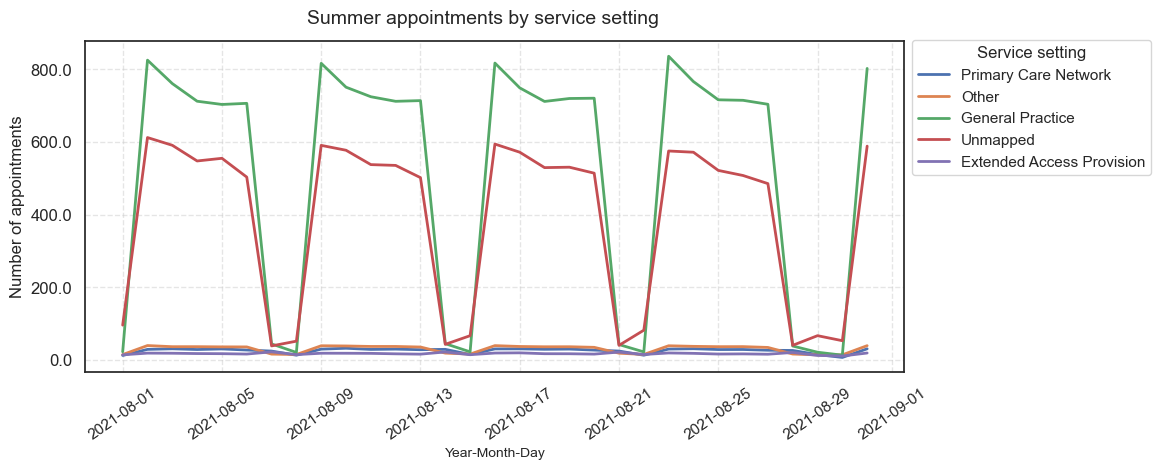

In [1093]:
# Create a lineplot.
# Set figure size.
sns.set(rc={'figure.figsize':(9, 4)})

# Set the plot style as white.
sns.set_style('white')
# sns.set_style('ticks')

# Plot multiple variables with the same x-axis.
nc_fig_4_summ, ax = plt.subplots()
nc_fig_4_summ.tight_layout() # fixes overlapping titles
nc_fig_4_summ.suptitle("Summer appointments by service setting", fontsize=14, y=1.02)

# plot data
sns.lineplot(x='appointment_date', 
            y='count_of_appointments',
            data=nc_ss_summer,
            hue='service_setting',
            ci=None,
            linewidth=2)
ax.set_ylabel("Number of appointments")
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.grid(True, linestyle="--", alpha=0.5)

# add axis labels
ax.set_xlabel("Year-Month-Day", fontsize=10)

# Rename legend
plt.legend(title="Service setting", bbox_to_anchor=(1, 1.027), loc='upper left')

plt.xticks(rotation=35)

#### ----->nc_fig_4_autm

**Autumn (September to November 2021):**

In [1096]:
# Look at September to November 2021 in more detail to allow a closer look.
nc_ss_autumn = nc.loc[
    (nc['appointment_date'] >= '2021-09-01') &
    (nc['appointment_date'] <= '2021-11-30')][[
        'appointment_date',
        'service_setting',
        'count_of_appointments']]

# nc_ss_autumn.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

(array([18871., 18885., 18901., 18915., 18932., 18946., 18962.]),
 [Text(18871.0, 0, '2021-09-01'),
  Text(18885.0, 0, '2021-09-15'),
  Text(18901.0, 0, '2021-10-01'),
  Text(18915.0, 0, '2021-10-15'),
  Text(18932.0, 0, '2021-11-01'),
  Text(18946.0, 0, '2021-11-15'),
  Text(18962.0, 0, '2021-12-01')])

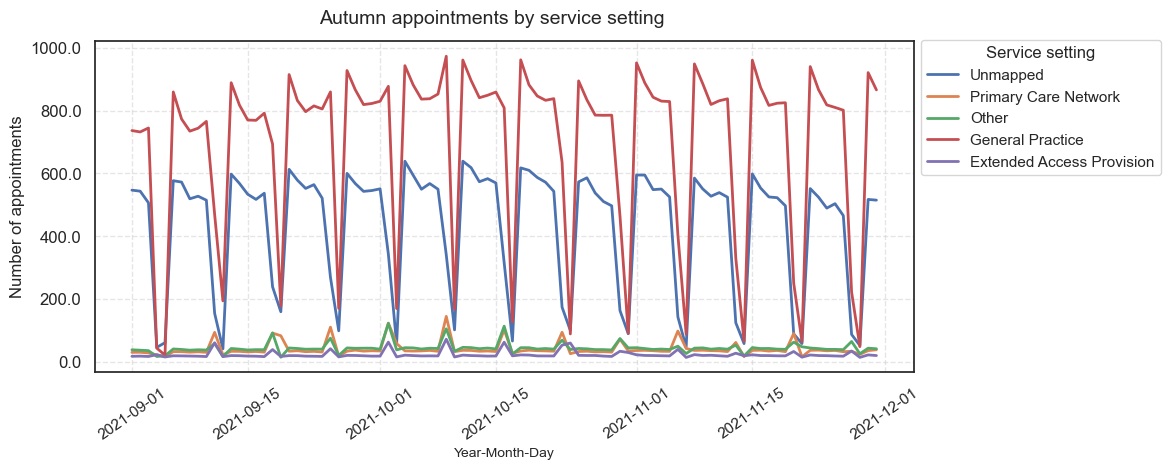

In [1097]:
# Create a lineplot.
# Set figure size.
sns.set(rc={'figure.figsize':(9, 4)})

# Set the plot style as white.
sns.set_style('white')
# sns.set_style('ticks')

# Plot multiple variables with the same x-axis.
nc_fig_4_autm, ax = plt.subplots()
nc_fig_4_autm.tight_layout() # fixes overlapping titles
nc_fig_4_autm.suptitle("Autumn appointments by service setting", fontsize=14, y=1.02)

# plot data
sns.lineplot(x='appointment_date', 
            y='count_of_appointments',
            data=nc_ss_autumn,
            hue='service_setting',
            ci=None,
            linewidth=2)
ax.set_ylabel("Number of appointments")
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.grid(True, linestyle="--", alpha=0.5)

# add axis labels
ax.set_xlabel("Year-Month-Day", fontsize=10)

# Rename legend
plt.legend(title="Service setting", bbox_to_anchor=(1, 1.027), loc='upper left')

plt.xticks(rotation=35)

**Winter (December to February 2022):**

In [1099]:
# Look at December to February 2022 in more detail to allow a closer look.
nc_ss_winter = nc.loc[
    (nc['appointment_month'] >= '2021-12') &
    (nc['appointment_month'] <= '2022-02')][[
        'appointment_date',
        'appointment_month',
        'service_setting',
        'count_of_appointments']]

# nc_ss_winter.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

(array([18962., 18976., 18993., 19007., 19024., 19038., 19052.]),
 [Text(18962.0, 0, '2021-12-01'),
  Text(18976.0, 0, '2021-12-15'),
  Text(18993.0, 0, '2022-01-01'),
  Text(19007.0, 0, '2022-01-15'),
  Text(19024.0, 0, '2022-02-01'),
  Text(19038.0, 0, '2022-02-15'),
  Text(19052.0, 0, '2022-03-01')])

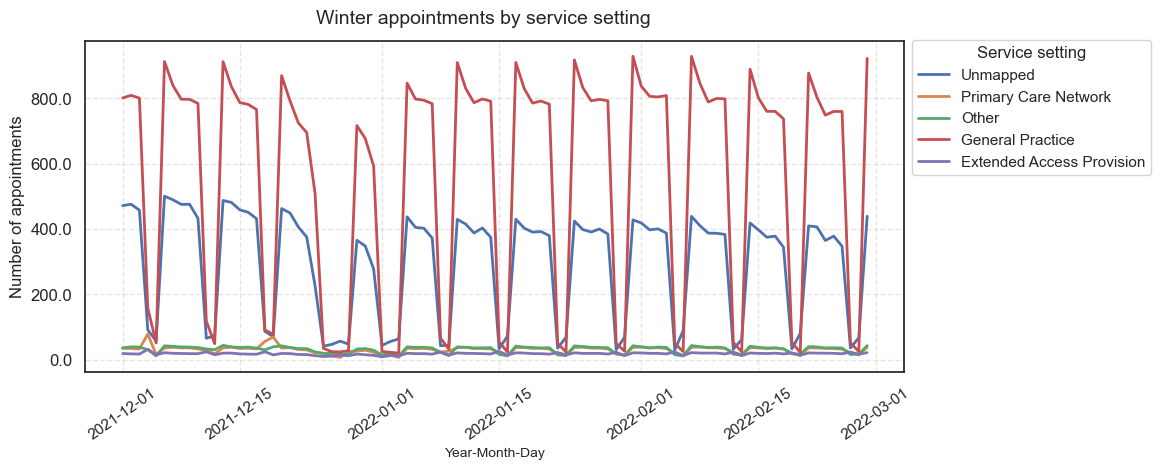

In [1100]:
# Create a lineplot.
# Set figure size.
sns.set(rc={'figure.figsize':(9, 4)})

# Set the plot style as white.
sns.set_style('white')
# sns.set_style('ticks')

# Plot multiple variables with the same x-axis.
nc_fig_4_wint, ax = plt.subplots()
nc_fig_4_wint.tight_layout() # fixes overlapping titles
nc_fig_4_wint.suptitle("Winter appointments by service setting", fontsize=14, y=1.02)

# plot data
sns.lineplot(x='appointment_date', 
            y='count_of_appointments',
            data=nc_ss_winter,
            hue='service_setting',
            ci=None,
            linewidth=2)
ax.set_ylabel("Number of appointments")
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.grid(True, linestyle="--", alpha=0.5)

# add axis labels
ax.set_xlabel("Year-Month-Day", fontsize=10)

# Rename legend
plt.legend(title="Service setting", bbox_to_anchor=(1, 1.027), loc='upper left')

plt.xticks(rotation=35)

**Spring (March to May 2022):**

In [1102]:
# Look at March to May 2022 in more detail to allow a closer look.
nc_ss_spring = nc.loc[
    (nc['appointment_month'] >= '2022-03') &
    (nc['appointment_month'] <= '2022-05')][[
        'appointment_date',
        'appointment_month',
        'service_setting',
        'count_of_appointments']]

# nc_ss_spring.apply(lambda x: x.agg('{:,d}'.format) if x.dtype=='int64' else x)

(array([19052., 19066., 19083., 19097., 19113., 19127., 19144.]),
 [Text(19052.0, 0, '2022-03-01'),
  Text(19066.0, 0, '2022-03-15'),
  Text(19083.0, 0, '2022-04-01'),
  Text(19097.0, 0, '2022-04-15'),
  Text(19113.0, 0, '2022-05-01'),
  Text(19127.0, 0, '2022-05-15'),
  Text(19144.0, 0, '2022-06-01')])

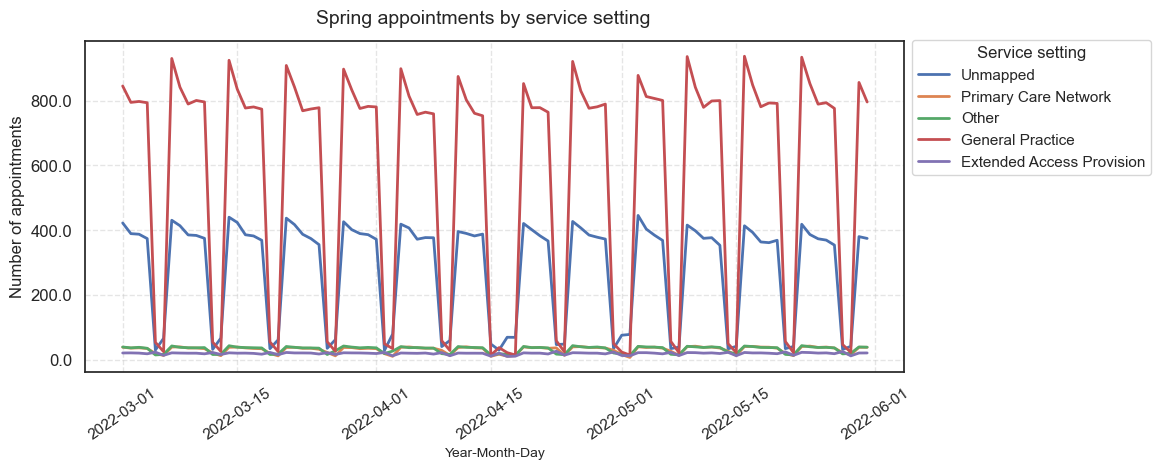

In [1103]:
# Create a lineplot.
# Set figure size.
sns.set(rc={'figure.figsize':(9, 4)})

# Set the plot style as white.
sns.set_style('white')
# sns.set_style('ticks')

# Plot multiple variables with the same x-axis.
nc_fig_4_spri, ax = plt.subplots()
nc_fig_4_spri.tight_layout() # fixes overlapping titles
nc_fig_4_spri.suptitle("Spring appointments by service setting", fontsize=14, y=1.02)

# plot data
sns.lineplot(x='appointment_date', 
            y='count_of_appointments',
            data=nc_ss_spring,
            hue='service_setting',
            ci=None,
            linewidth=2)
ax.set_ylabel("Number of appointments")
ax.set_xticklabels(nc_ss_spring['appointment_date'], minor=True)
ax.set_yticklabels(ax.get_yticks(), size=12)
ax.grid(True, linestyle="--", alpha=0.5)

# add axis labels
ax.set_xlabel("Year-Month-Day", fontsize=10)

# Rename legend
plt.legend(title="Service setting", bbox_to_anchor=(1, 1.027), loc='upper left')

plt.xticks(rotation=35)

# - Analyst's observations:

"Scheduling a weekend GP appointment in the UK is generally not considered easy as most GP surgeries are closed on weekends, but you can access appointments through "extended access" services by contacting your GP practice during normal hours or calling NHS 111 when your practice is closed, which will usually direct you to a dedicated "out of hours" service offering weekend appointments; availability may vary depending on your location and practice".

- Instead of increase in staffing it is worth evening out existing service utilisation throughout a week by increasing accessibility of extended access weekend [(NHS UK, 2023)](https://www.nhs.uk/nhs-services/gps/gp-appointments-and-bookings/#:~:text=Call%20your%20GP%20surgery%20or,another%20local%20NHS%20service) appointments (simplify bookings, or introduce walk-ins)
- Analysis by season essentially highlights expected weekends drop. 
- GP service setting was the most popular for NHS North West London ICB-W2U3Z from 1 January to 1 June 2022

# Summary

**AR**:

- 92% of appointments were attended (over 167 million), 
- 50% are with GP and 46% with other practice staff, 
- 62% were face-to-face and 34% over the phone, 
- 42% on the same day and 20% within 2-7 days since scheduling.

**NC**:
- 91% of appointments are with GP,
- 87% of appointments are Care Related Encounter,
- 34% of appointments are General Consultation Routine, 19% - General Consultation Acute, 14% - Clinical Triage.

**AD** (2021-12 - 2022-06): 
- "The Royal College of General Practitioners (RCGP) recommends that GP appointments in the UK should be at least 15 minutes long. However, many practices still offer 10-minute appointments" [(bmj)](https://www.bmj.com/content/365/bmj.l2389#:~:text=GP%20appointments%20in%20the%20UK,that%20I%20usually%20run%20late.), [(NHS England)](https://www.england.nhs.uk/gp/case-studies/600-gp-hours-released-a-year-after-reducing-inappropriate-appointments-chiswick-health-practice-london/#:~:text=Most%20of%20the%20GPs%20have,Impact)
- 37% of appointments take from 1-10 minutes,
- only 25% take 11-20 minutes,
- 24% are not market and could equally last 0 - over 60 minutes.

**AD** ar_fig_distribution_outliers:
- Outliers are not excluded as they are a small number of GP and extended access weekend appointments [(NHS England)](https://www.england.nhs.uk/gp/investment/gp-contract/network-contract-directed-enhanced-service-des/enhanced-access-faqs/#:~:text=Sundays%20are%20not%20a%20mandatory,adjusted%20population%20required%20each%20week.)

**NC & AR** ar_fig_hcp, nc_fig_nogcroutine, nc_fig_gcroutine, ar_nc_fig_att_sameday_mode_nc:
- During 1st lockdown Telephone appointments replaced some fact-to-face appointments. Face-to-face reach the highest numbers in Autumn season.
- - Need to know national category for the COVID period to check whether categories corresponding to those that could offer to be seen the same day [(NHS England)](https://www.england.nhs.uk/long-read/recording-gp-appointments-consolidated-guidance/) could be conducted over the phone instead of face-to-face for resource use optimisation and increased attendance

**AR** ar_fig_total_avg_capacity, ar_fig_att_vs_dna, ar_fig_att_vs_dna_mode, ar_fig_att_vs_dna_bn:
- Increase in appointments counts are identified during second half of every season of a year, except Autum'2020 when 2nd COVID lockdown took place.
- The highest seasonal number of appointments takes place during school breaks/half-terms.

"According to NHS Digital data, in 2022, the average number of GP appointments per month in England was around 30 million, based on figures like the 30.1 million appointments recorded in March 2022" [(NHS Digital)](https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/march-2022). The monthly benchmark has been reached through the busiest period.
- End of November 2021 - the 1st half-term - is the busiest month.
- During the busiest time pre-Xmas - face-to-face are most attended as well as most missed.
- During 1st lockdown same day appointments were more often missed than those scheduled 2-7 and 8-14 ahead. Opposite in Oct-Nov 2021. Same day highest during the busiest period.

"Scheduling a weekend GP appointment in the UK is generally not considered easy as most GP surgeries are closed on weekends, but you can access appointments through "extended access" services by contacting your GP practice during normal hours or calling NHS 111 when your practice is closed, which will usually direct you to a dedicated "out of hours" service offering weekend appointments; availability may vary depending on your location and practice".
- Instead of increase in staffing it is worth evening out existing service utilisation throughout a week by increasing accessibility of extended access weekend [(NHS UK, 2023)](https://www.nhs.uk/nhs-services/gps/gp-appointments-and-bookings/#:~:text=Call%20your%20GP%20surgery%20or,another%20local%20NHS%20service) appointments (simplify bookings, or introduce walk-ins)
- Analysis by season essentially highlights expected weekends drop. 

## Recommendations 

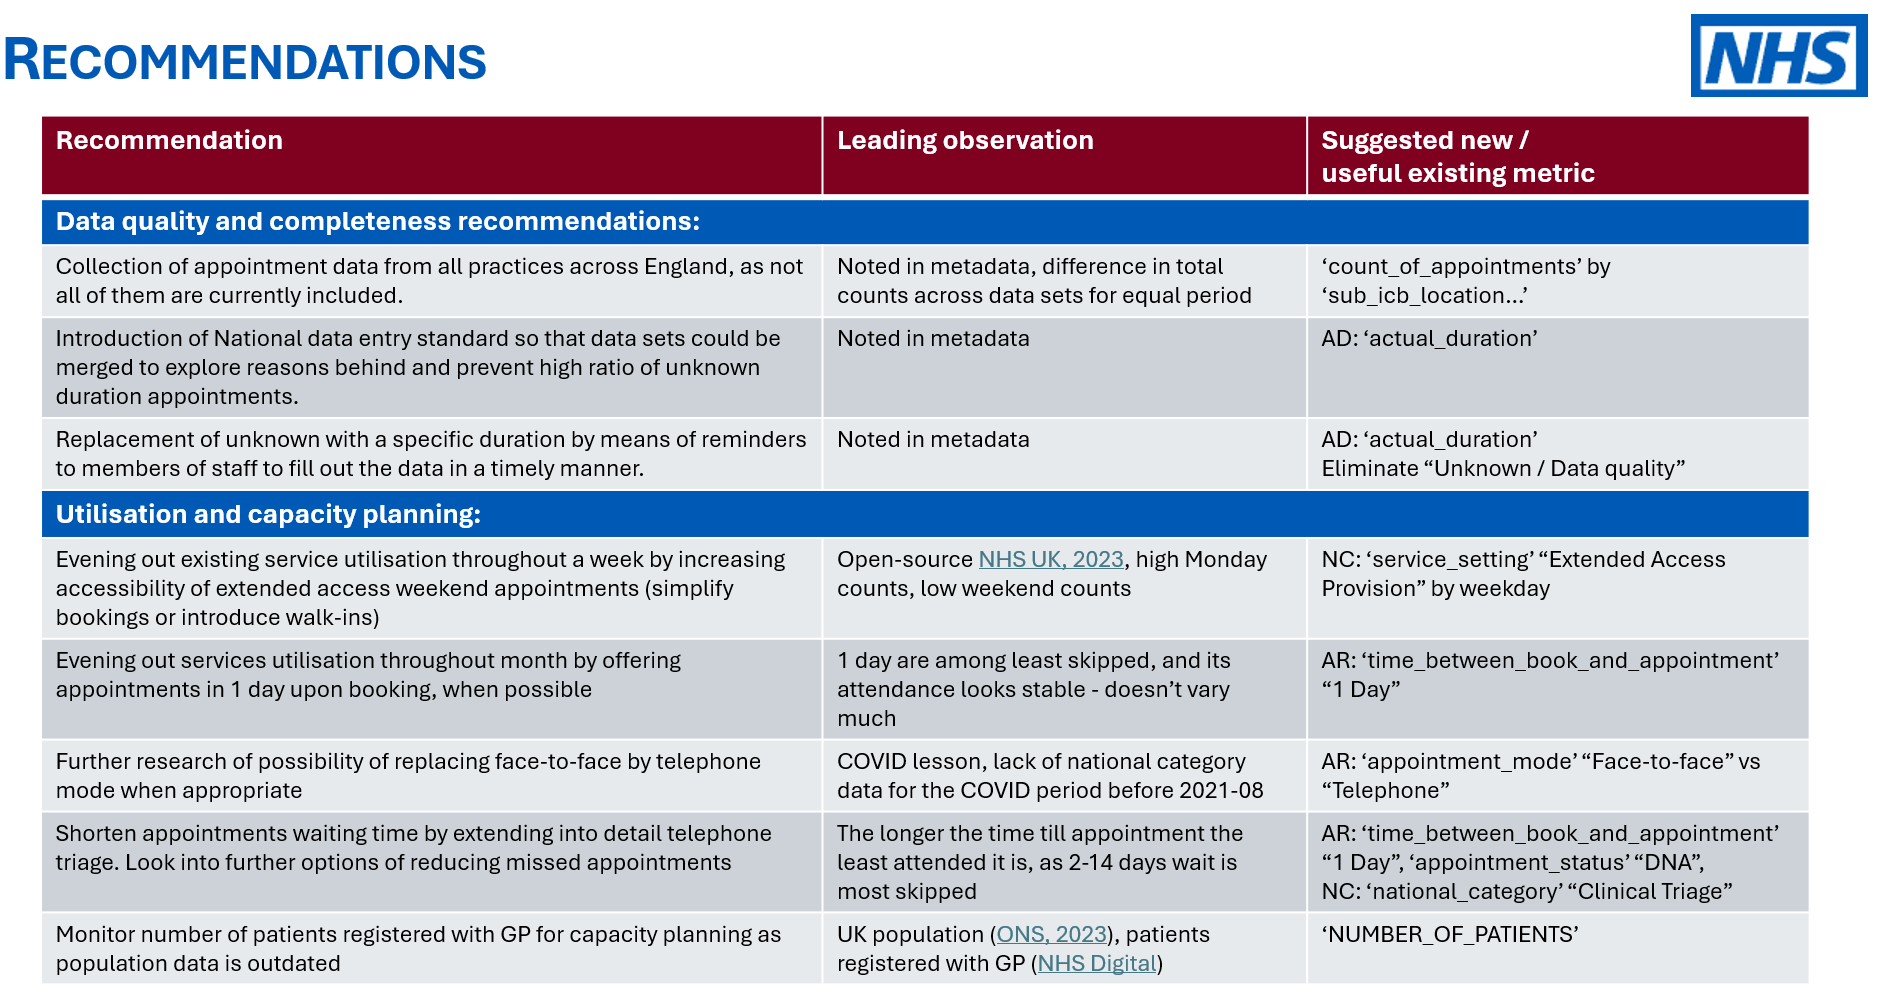

# Save fig(s):

In [1112]:
# # Save figures to PNG

# ad_fig.savefig('ad_fig.png', bbox_inches='tight')
# plt.close(ad_fig)

# ar_fig.savefig('ar_fig.png', bbox_inches='tight')
# plt.close(ar_fig)

# nc_fig.savefig('nc_fig.png', bbox_inches='tight')
# plt.close(nc_fig)

# nc_fig_4_autm.savefig('nc_fig_4_autm.png', bbox_inches='tight')
# plt.close(nc_fig_4_autm)

# ar_fig_total_capacity.savefig('ar_fig_total_capacity.png', bbox_inches='tight')
# plt.close(ar_fig_total_capacity)

# nc_fig_week_day.savefig('nc_fig_week_day.png', bbox_inches='tight')
# plt.close(nc_fig_week_day)

# nc_fig_4_autm.savefig('nc_fig_4_autm.png', bbox_inches='tight')
# plt.close(nc_fig_4_autm)

# ar_nc_fig_hcp.savefig('ar_nc_fig_hcp.png', bbox_inches='tight')
# plt.close(ar_nc_fig_hcp)

# ar_fig_att_vs_dna_mode.savefig('ar_fig_att_vs_dna_mode.png', bbox_inches='tight')
# plt.close(ar_fig_att_vs_dna_mode)

# ar_nc_fig_att_sameday_mode_nc.savefig('ar_nc_fig_att_sameday_mode_nc.png', bbox_inches='tight')
# plt.close(ar_nc_fig_att_sameday_mode_nc)

# ar_fig_att_vs_dna_bn.savefig('ar_fig_att_vs_dna_bn.png', bbox_inches='tight')
# plt.close(ar_fig_att_vs_dna_bn)

# Athor's remarks

This Jupyter notebook is the final revised version of the analysis.
The extended original list of utilised Python code and functions is displayed in this section:

In [1115]:
# pd.info() replaced pd.dtypes, pd.columns as its output includes it

print("ad data set:\n", ad.dtypes)
print("ad data set:\n", ar.dtypes)
print("ad data set:\n", nc.dtypes)
print("ad data set:\n", tw.dtypes)

ad data set:
 sub_icb_location_code                object
sub_icb_location_ons_code            object
sub_icb_location_name                object
icb_ons_code                         object
region_ons_code                      object
appointment_date             datetime64[ns]
actual_duration                      object
count_of_appointments                 int64
region_name                          object
year                                  int32
month                                 int32
appointment_month                    object
dtype: object
ad data set:
 icb_ons_code                                 object
appointment_month                    string[python]
appointment_status                           object
hcp_type                                     object
appointment_mode                             object
time_between_book_and_appointment            object
count_of_appointments                         int64
year                                          int64
month         

Some useful code links:
Barplots annotations [link](https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html)

# TODO:

- options.display
- Assignment 4: lable every point in data https://stackoverflow.com/a/52244724/21407272
- Assignment 4: for % https://www.geeksforgeeks.org/applying-lambda-functions-to-pandas-dataframe/
- check explanatory power of categories - scatterplots, replot
- Assignment 4: axis days clean up https://www.earthdatascience.org/courses/scientists-guide-to-plotting-data-in-python/plot-with-matplotlib/introduction-to-matplotlib-plots/plot-time-series-data-in-python/
- make SQL schema
- webscrape regions names and registered data set